# Tugas Besar 1 IF3270 Pembelajaran Mesin Feedforward Neural Network

### Activation Function


In [1]:
import numpy as np

def tanh(x):
    return np.tanh(x)

def softmax(x):
    e = np.exp(np.clip(x, -100, 100))
    return e / np.sum(e, axis=1, keepdims=True)

def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


### Function Derivative

In [2]:
import numpy as np

# turunan fungsi aktivasi
def linearDerivative(net):
    return 1

def tanDerivative(net):
    return  1 - np.tanh(net) ** 2

import numpy as np

def softmaxDerivative(net, threshold=100):
    net = np.array(net)
    batch_size, num_neurons = net.shape

    softmax_output = np.exp(np.clip(net, -100, 100))
    softmax_output /= np.sum(softmax_output, axis=1, keepdims=True)

    if num_neurons > threshold:
        return softmax_output * (1 - softmax_output)

    softmax_jacobian = np.zeros((batch_size, num_neurons, num_neurons))

    for b in range(batch_size):
        for i in range(num_neurons):
            for j in range(num_neurons):
                if i == j:
                    softmax_jacobian[b, i, j] = softmax_output[b, i] * (1 - softmax_output[b, j])
                else:
                    softmax_jacobian[b, i, j] = -softmax_output[b, i] * softmax_output[b, j]

    return softmax_jacobian


def sigmoidDerivative(net):
    net = np.array(net)
    return net * (1 - net)

def reluDerivative(net):
    net = np.array(net)
    return np.where(net > 0, 1, 0)

# turunan fungsi loss
def mseDerivative(o, target):
    o = np.array(o)
    batch_size, num_neurons = o.shape
    target = np.array(target).T
    return (o - target) * 2/batch_size

def binaryDerivative(o, target):
    o = np.array(o)
    target = np.array(target).T
    batch_size, num_neurons = o.shape
    return (o - target)/(o*(1-o)) * 1/batch_size

def categoricalDerivative(o, target):
    o = np.array(o)
    target = np.array(target).T
    batch_size, num_neurons = o.shape
    return -(target / o) * (1 / batch_size)

# hitung gradien
def outputLayer(o, net, target, activFunc, LossFunc):
    if LossFunc == "binary":
        loss =  binaryDerivative(o, target)
    elif LossFunc == "categorical":
        loss = categoricalDerivative(o, target)
    else:
        loss =  mseDerivative(o, target)

    if activFunc=="softmax":
        jacobian = softmaxDerivative(net)
        if jacobian.ndim == 2:
            diag_jacobian = jacobian
        else:
            diag_jacobian = np.diagonal(jacobian, axis1=1, axis2=2)
        return loss * diag_jacobian.T
    elif activFunc =="tanh":
        return loss * tanDerivative(net).T
    elif activFunc == "sigmoid":
        return loss * sigmoidDerivative(net).T
    elif activFunc == "relu":
        return loss * reluDerivative(net).T
    else:
        return loss * linearDerivative(net)


def hiddenLayer(w, net, delta, activFunc):
    if activFunc=="softmax":
        jacobian = softmaxDerivative(net)
        if jacobian.ndim == 2:
            diag_jacobian = jacobian
        else:
            diag_jacobian = np.diagonal(jacobian, axis1=1, axis2=2)
        return np.dot(w, delta) * diag_jacobian
    elif activFunc =="tanh":
        return np.dot(w, delta) * tanDerivative(net)
    elif activFunc == "sigmoid":
        return np.dot(w, delta) * sigmoidDerivative(net)
    elif activFunc == "relu":
        return np.dot(w, delta) * reluDerivative(net)
    else:
        return np.dot(w, delta) * linearDerivative(net)


### Layer Model

In [3]:
import numpy as np

class Layers:
    def __init__(self, n_inputs: int, n_neurons: int, activ_func, use_bias=1):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.activ_func = activ_func
        self.use_bias = use_bias

        self.weight = np.random.randn((n_inputs + use_bias), n_neurons)


### FFNN Model

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import sys
import time

class FFNN:
    def __init__(self, batch_size: int, learning_rate: float, epoch: int, verbose: int, loss_func, weight_init, seed=int):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.verbose = verbose
        self.loss_func = loss_func
        self.weight_init = weight_init
        self.loss_train_history = []
        self.loss_val_history = []
        self.seed = seed or None

        self.input_train: list[list[float]] = []
        self.input_val: list[list[float]] = []
        self.target_train: list[list[float]] = []
        self.target_val: list[list[float]] = []
        self.layers: list[Layers] = []
        self.delta_gradien: list[np.ndarray] = []

    def initDeltaGradien(self):
        self.delta_gradien = [np.zeros((layer.n_inputs+1, layer.n_neurons)) for layer in self.layers]

    def initWeight(self, lower_bound=-0.5, upper_bound=0.5, mean=0.0, variance=1.0):
        if self.weight_init == "custom":
            bxh = np.array([[0.35, 0.35]])
            wxh = np.array([[0.15, 0.25],
                            [0.2, 0.3]])
            self.layers[0].weight = np.vstack((bxh, wxh))
            bhy = np.array([[0.6, 0.6]])
            why = np.array([[0.4, 0.5],
                            [0.45, 0.55]])
            self.layers[1].weight = np.vstack((bhy, why))
        else:
            for layer in self.layers:
                fan_in = layer.n_inputs
                fan_out = layer.n_neurons

                if self.seed is not None:
                    np.random.seed(self.seed)
                if self.weight_init == "zero":
                    layer.weight = np.zeros((layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "uniform":
                    layer.weight = np.random.uniform(low=lower_bound, high=upper_bound, size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "normal":
                    layer.weight = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "xavier":
                    variance_xavier = 2 / (fan_in + fan_out)
                    layer.weight = np.random.normal(loc=0.0, scale=np.sqrt(variance_xavier), size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "he":
                    variance_he = 2 / fan_in
                    layer.weight = np.random.normal(loc=0.0, scale=np.sqrt(variance_he), size=(layer.n_inputs + 1, layer.n_neurons))

    def calcLoss(self, output: list[float], target: list[float]):
        if self.loss_func == "mse":
            return np.mean((np.array(target) - np.array(output)) ** 2)
        elif self.loss_func == "binary":
            output = np.array(output, dtype=np.float64)
            target = np.array(target, dtype=np.float64)
            return -np.mean(target * np.log(output + 1e-9) + (1 - target) * np.log(1 - output))
        elif self.loss_func == "categorical":
            return -np.mean(np.sum(target * np.log(output + 1e-9), axis=1))

    def updateWeight(self):
        for idx, layer in enumerate(self.layers):
            layer.weight -= self.delta_gradien[idx]

    def updateGradien(self, layer_idx: int, delta: np.ndarray, input: np.ndarray):
        grad = self.learning_rate * (np.array(input) @ np.array(delta).T)
        self.delta_gradien[layer_idx] = grad


    def addInputTarget(self, input_train: list[float], input_val: list[float], target_train: list[float], target_val: list[float]):
        self.input_train.append(input_train)
        self.input_val.append(input_val)
        self.target_train.append(target_train)
        self.target_val.append(target_val)

    def addHiddenLayer(self, layer: Layers):
        self.layers.append(layer)

    def plot_weight_distribution(self, layers_to_plot: list[int] = None):
        if layers_to_plot is None:
            layers_to_plot = list(range(len(self.layers)))

        num_layers = len(layers_to_plot)
        fig, ax = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4), sharey=True)

        if num_layers == 1:
            ax = [ax]

        for i, layer_idx in enumerate(layers_to_plot):
            if layer_idx < 0 or layer_idx >= len(self.layers):
                print(f"Layer {layer_idx+1} tidak valid.")
                continue

            weights = self.layers[layer_idx].weight.flatten()
            ax[i].hist(weights, bins=30, alpha=0.7, color='b', edgecolor='black')
            ax[i].set_title(f'Layer {layer_idx+1}')
            ax[i].set_xlabel('Nilai Bobot')
            ax[i].set_ylabel('Frekuensi')
            ax[i].grid(True, linestyle='--', alpha=0.6)

        plt.suptitle('Distribusi Bobot Per Layer', fontsize=14)
        plt.tight_layout()
        plt.show()


    def plot_gradient_distribution(self, layers_to_plot: list[int] = None):
        if layers_to_plot is None:
            layers_to_plot = list(range(len(self.delta_gradien)))

        num_layers = len(layers_to_plot)
        fig, ax = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4), sharey=True)

        if num_layers == 1:
            ax = [ax]

        for i, layer_idx in enumerate(layers_to_plot):
            if layer_idx < 0 or layer_idx >= len(self.delta_gradien):
                print(f"Layer {layer_idx+1} tidak valid.")
                continue

            grad = self.delta_gradien[layer_idx].flatten()
            ax[i].hist(grad, bins=30, alpha=0.7, color='r', edgecolor='black')
            ax[i].set_title(f'Layer {layer_idx+1}')
            ax[i].set_xlabel('Nilai Gradien')
            ax[i].set_ylabel('Frekuensi')
            ax[i].grid(True, linestyle='--', alpha=0.6)

        plt.suptitle('Distribusi Gradien Per Layer', fontsize=14)
        plt.tight_layout()
        plt.show()

    def feedForward(self):
        self.initWeight()
        start_time = time.time()
        self.loss_train_history = []
        self.loss_val_history = []

        for j in range(self.epoch):
            self.initDeltaGradien()
            train_error = 0
            epoch_start_time = time.time()

            for i, batch in enumerate(self.input_train):
                inputs: list[list[float]] = []
                nets: list[list[float]] = []
                self.initDeltaGradien()

                batch = np.array(batch)
                batch_size = batch.shape[0]
                bias = np.ones((batch_size, 1))
                current = np.hstack((bias, batch))
                inputs.append(current.copy().transpose().tolist())

                for layer in self.layers:
                    net = np.dot(current, layer.weight)
                    current = layer.activ_func(net)
                    nets.append(net.copy().transpose().tolist())
                    if layer != self.layers[-1]:
                        bias = np.ones((batch_size, 1))
                        current = np.hstack((bias, current))
                    inputs.append(current.copy().transpose().tolist())

                train_error += self.calcLoss(current, self.target_train[i])
                self.backPropagation(inputs, nets, self.target_train[i])
                self.updateWeight()

            self.loss_train_history.append(train_error)
            val_pred = self.predict(self.input_val)
            val_error = self.calcLoss(val_pred, self.target_val)
            self.loss_val_history.append(val_error)

            epoch_duration = time.time() - epoch_start_time
            total_elapsed = time.time() - start_time
            estimated_total_time = (total_elapsed / (j + 1)) * self.epoch
            eta = estimated_total_time - total_elapsed

            if self.verbose == 1:
                bar_length = 30
                progress = (j + 1) / self.epoch
                bar = "=" * int(bar_length * progress) + "-" * (bar_length - int(bar_length * progress))
                sys.stdout.write(f"\rEpoch {j+1}/{self.epoch} [{bar}] {progress*100:.1f}% - Training Loss: {train_error:.4f} - Validation Loss: {val_error:.4f} - {epoch_duration:.2f}s/epoch - ETA: {eta:.2f}s")
                sys.stdout.flush()

        print("\n         Training History          ")
        print("==================================")
        print("Epoch | Train Loss | Val Loss")
        print("-----------------------------------")
        for epoch, (train_loss, val_loss) in enumerate(zip(self.loss_train_history, self.loss_val_history)):
            print(f"{epoch+1:5d} |  {train_loss:.6f}  | {val_loss:.6f}")
        print("===================================")


    def backPropagation(self, inputs, netsLayer, target):
        # print(f"Total layers : {len(self.layers)}")
        i = len(self.layers) - 1
        delta1: np.ndarray = None

        while i >= -1:
            nets = np.array(netsLayer[i]).T

            if i == len(self.layers) - 1:  # Output layer
                if self.layers[i].activ_func == softmax:
                    delta1 = outputLayer(inputs[i+1], nets, target,"softmax",self.loss_func)
                elif self.layers[i].activ_func == tanh:
                    delta1 = outputLayer(inputs[i+1], nets, target,"tanh",self.loss_func)
                elif self.layers[i].activ_func == sigmoid:
                    delta1 = outputLayer(inputs[i+1], nets, target,"sigmoid",self.loss_func)
                elif self.layers[i].activ_func == relu:
                    delta1 = outputLayer(inputs[i+1], nets, target,"relu",self.loss_func)
                else: # linear
                    delta1 = outputLayer(inputs[i+1], nets, target,"linear",self.loss_func)

            else:  # Hidden layer
                # print("LAYERR",self.layers[i + 1].weight)
                if self.layers[i].activ_func == softmax:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "softmax")
                elif self.layers[i].activ_func == tanh:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "tanh")
                elif self.layers[i].activ_func == sigmoid:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "sigmoid")
                elif self.layers[i].activ_func == relu:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "relu")
                else: # linear
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "linear")

                self.updateGradien(i + 1, delta1,inputs[i+1])

                # print(f"Current input: {inputs[i+1][1:]}")
                # print(f"Current delta1: {delta1}")
                # print(f"Current All gradien: {self.delta_gradien}")
                # print(f"Current gradien: {self.delta_gradien[i + 1]}")
                delta1 = delta2

            i -= 1

    @staticmethod
    def visualize_network(ffnn):
        G = nx.DiGraph()
        layer_labels = []
        positions = {}

        for i in range(len(ffnn.input_train[0][0])):
            G.add_node(f"Input {i+1}")
            positions[f"Input {i+1}"] = (0, -i)
            layer_labels.append(f"Input {i+1}")

        prev_layer_neurons = [f"Input {i+1}" for i in range(len(ffnn.input_train[0][0]))]
        x_pos = 1

        for idx, layer in enumerate(ffnn.layers):
            current_layer_neurons = []
            bias_node = f"Bias {idx+1}"
            positions[bias_node] = (x_pos - 0.5, layer.n_neurons / 3)
            G.add_node(bias_node)
            layer_labels.append(bias_node)

            for n in range(layer.n_neurons):
                neuron_name = f"Layer {idx+1}\nNeuron {n+1}"
                G.add_node(neuron_name)
                current_layer_neurons.append(neuron_name)
                positions[neuron_name] = (x_pos, -n)
                layer_labels.append(neuron_name)

                weight_bias = layer.weight[0][n]
                gradient_bias = ffnn.delta_gradien[idx][0][n]
                G.add_edge(bias_node, neuron_name, weight=f"W: {weight_bias:.2f}\nG: {gradient_bias:.2f}")

                for prev_neuron in prev_layer_neurons:
                    weight_idx = prev_layer_neurons.index(prev_neuron) + 1
                    weight = layer.weight[weight_idx][n]
                    gradient = ffnn.delta_gradien[idx][weight_idx][n]
                    G.add_edge(prev_neuron, neuron_name, weight=f"W: {weight:.2f}\nG: {gradient:.2f}")

            prev_layer_neurons = current_layer_neurons
            x_pos += 1

        plt.figure(figsize=(12, 8))
        nx.draw(G, positions, with_labels=True, node_color='pink', node_size=1000, font_size=10, font_color='darkblue')

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_color='red', label_pos=0.25)

        plt.title("Feed Forward Neural Network Visualization (Weights & Gradients)")
        plt.show()

    def save_model(self, filename):
        model_data = {
            "layers": [layer.weight for layer in self.layers],
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "epoch": self.epoch,
            "loss_func": self.loss_func
        }
        with open(filename, "wb") as f:
            pickle.dump(model_data, f)
        print(f"Model berhasil disimpan ke {filename}")

    def load_model(self, filename):
        with open(filename, "rb") as f:
            model_data = pickle.load(f)

        if len(model_data["layers"]) != len(self.layers):
            raise ValueError("Jumlah layer pada model yang dimuat tidak sesuai.")

        for layer, weight in zip(self.layers, model_data["layers"]):
            layer.weight = weight

        self.batch_size = model_data["batch_size"]
        self.learning_rate = model_data["learning_rate"]
        self.epoch = model_data["epoch"]
        self.loss_func = model_data["loss_func"]

        print(f"Model berhasil dimuat dari {filename}")

    def plot_loss(self):
        plt.figure(figsize=(4, 2))
        plt.plot(self.loss_train_history, label='Training Loss', color='blue')
        plt.plot(self.loss_val_history, label='Validation Loss', color='red', linestyle='dashed')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


    def predict(self, X):
        batch = np.array(X)
        if batch.ndim == 3:
            batch = batch.reshape(batch.shape[1], batch.shape[2])

        batch_size = batch.shape[0]
        bias = np.ones((batch_size, 1))
        current = np.hstack((bias, batch))

        for layer in self.layers:
            net = np.dot(current, layer.weight)
            current = layer.activ_func(net)
            if layer != self.layers[-1]:
                bias = np.ones((batch_size, 1))
                current = np.hstack((bias, current))
        return current


## Model Analysis

In [5]:
import numpy as np
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pickle

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

# Load dataset MNIST
print("Loading MNIST dataset...")
t0 = time.time()
train_samples = 5000
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='auto')
y = y.astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)
y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)
print(f"Data loaded in {time.time() - t0:.2f} seconds.")


Loading MNIST dataset...
Data loaded in 8.68 seconds.


In [6]:
def train_ffnn(depth, width, learning_rate, activation, weight_init):
    ffnn = FFNN(batch_size=train_samples, learning_rate=learning_rate, epoch=3, verbose=1, loss_func='mse', weight_init=weight_init, seed=42)

    for _ in range(depth - 1):
        ffnn.addHiddenLayer(Layers(n_inputs=784 if _ == 0 else width, n_neurons=width, activ_func=activation))

    output_layer = Layers(n_inputs=width, n_neurons=10, activ_func=softmax)
    ffnn.addHiddenLayer(output_layer)

    ffnn.addInputTarget(X_train.tolist(), X_test, y_train_oh.tolist(), y_test_oh.tolist())
    ffnn.feedForward()
    ffnn.plot_loss()
    ffnn.plot_weight_distribution()
    ffnn.plot_gradient_distribution()

    y_pred = ffnn.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred_labels == y_test) * 100

    return ffnn, accuracy

### Pengaruh depth (banyak layer) dan width (banyak neuron per layer)


 Width 50 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1285 - Validation Loss: 0.1513 - 2.30s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.179843  | 0.141195
    2 |  0.140676  | 0.129591
    3 |  0.128476  | 0.151321


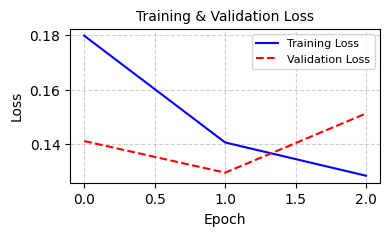

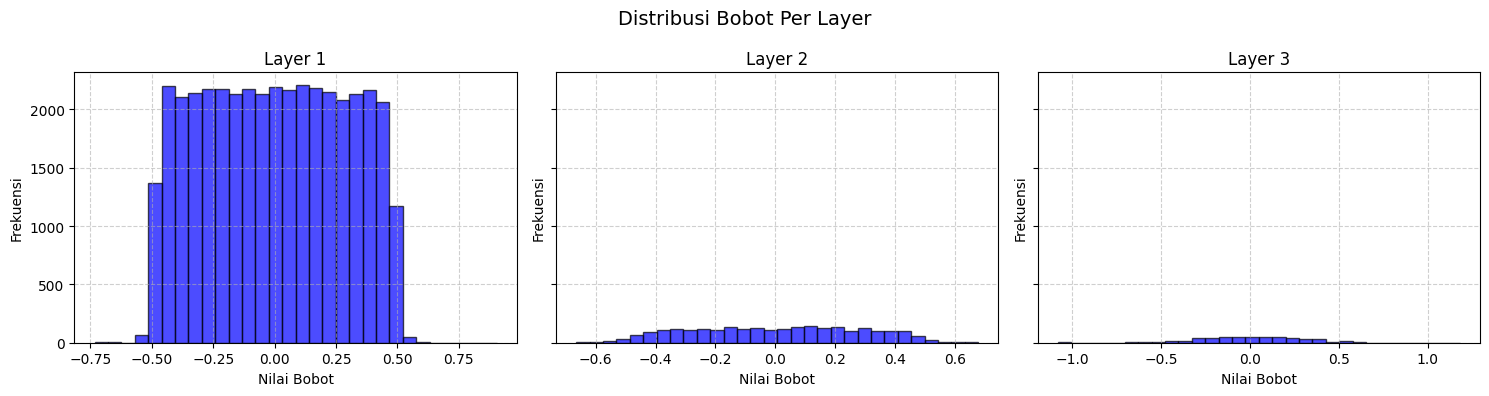

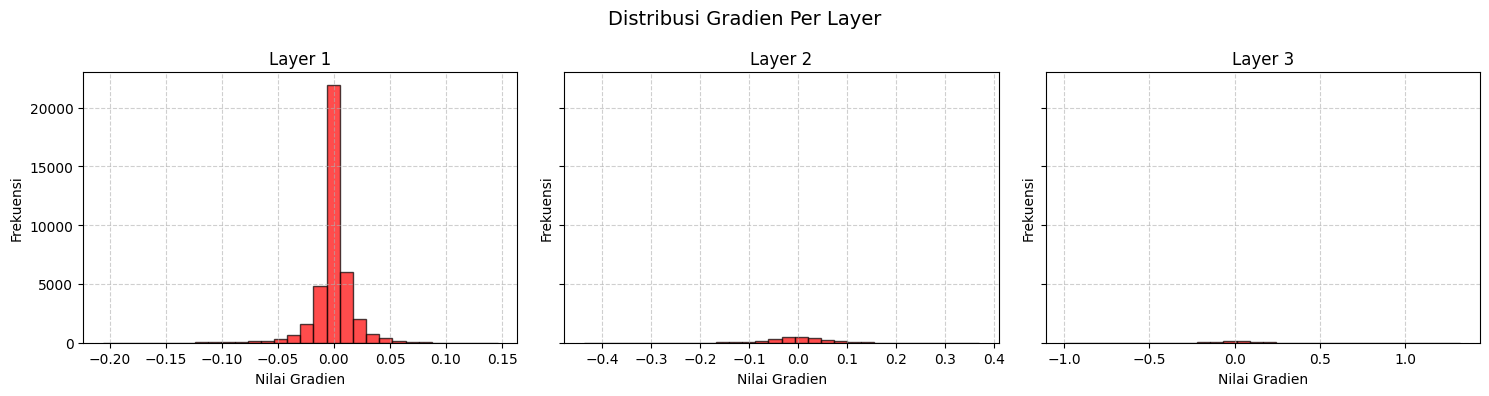


 Width 100 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1081 - Validation Loss: 0.0868 - 1.64s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.173624  | 0.106038
    2 |  0.105190  | 0.108369
    3 |  0.108064  | 0.086778


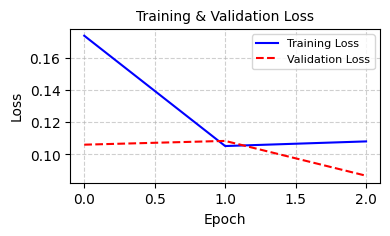

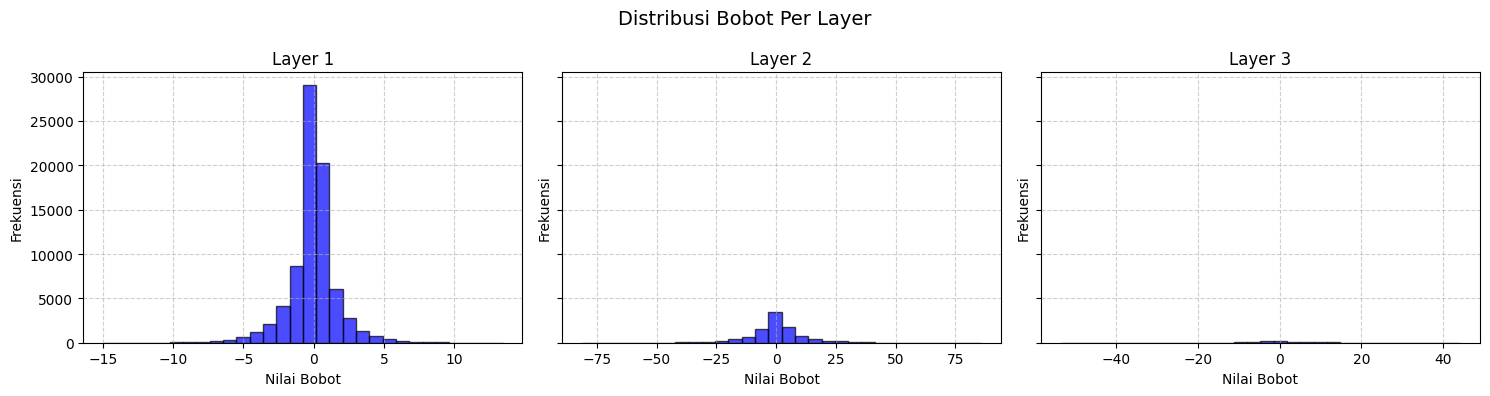

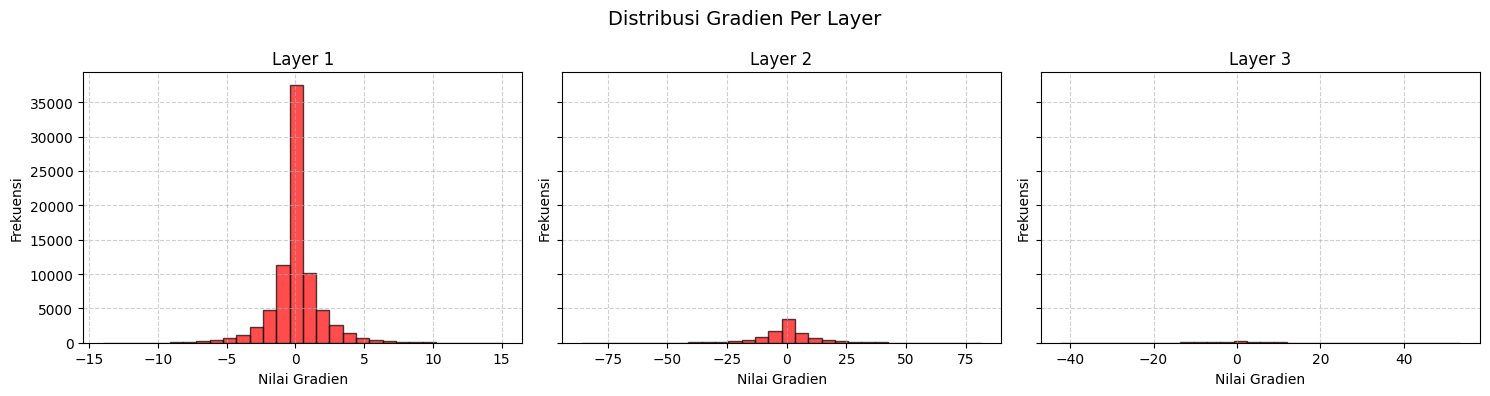


 Width 200 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1052 - Validation Loss: 0.0868 - 1.54s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.142150  | 0.111177
    2 |  0.110912  | 0.104950
    3 |  0.105221  | 0.086780


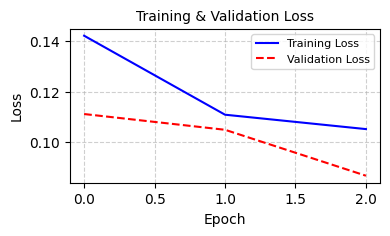

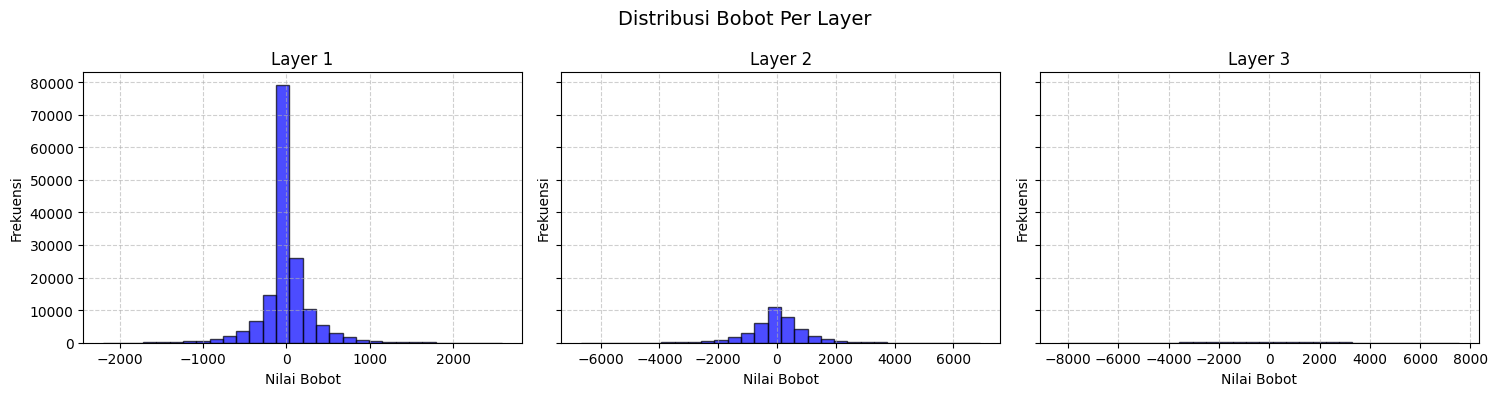

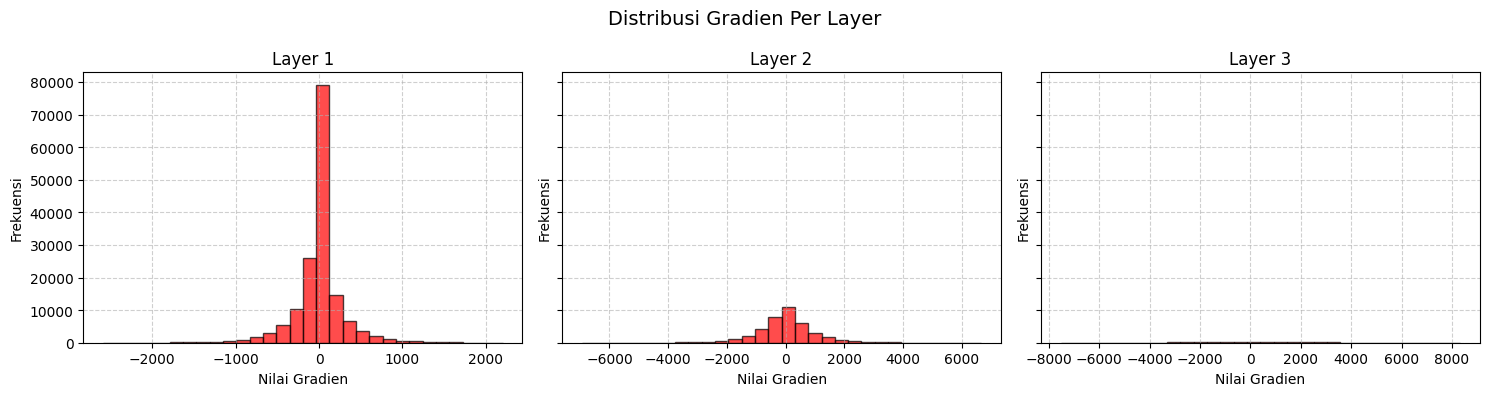

In [7]:
width_var = [50, 100, 200]

results = {}
for width in width_var:
    print(f"\n Width {width} Result\n")
    ffnn, acc = train_ffnn(depth=3, width=width, learning_rate=0.01, activation=linear, weight_init='uniform')
    results[f"Width {width}"] = acc


 Depth 2 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0871 - Validation Loss: 0.0662 - 1.59s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.172611  | 0.126821
    2 |  0.129239  | 0.088265
    3 |  0.087052  | 0.066180


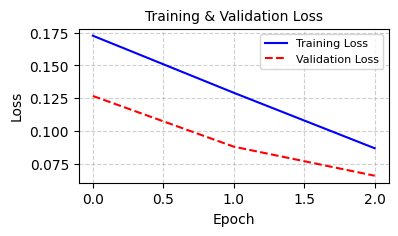

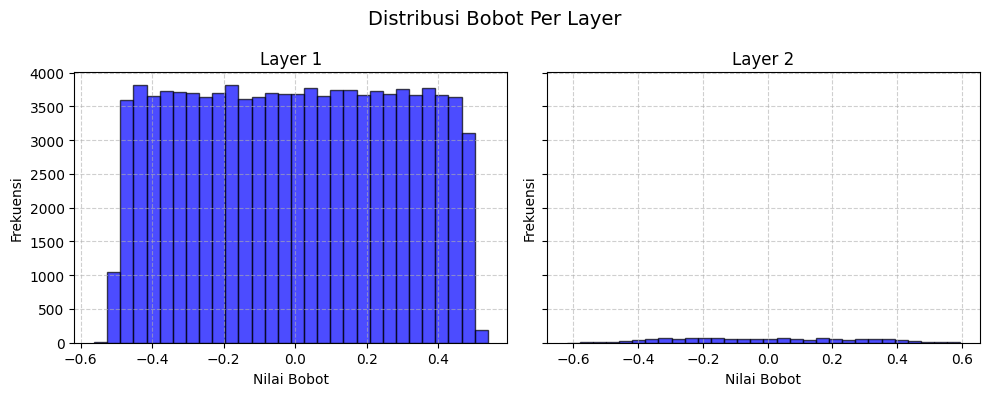

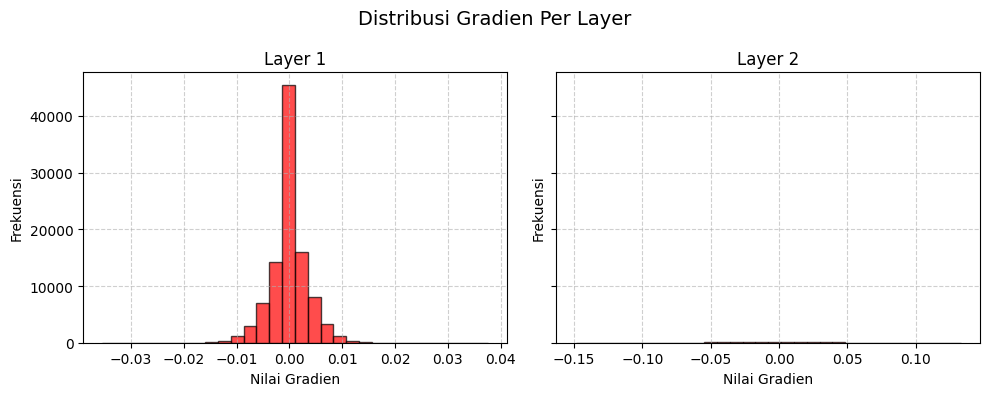


 Depth 4 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1055 - Validation Loss: 0.1059 - 1.48s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.121462  | 0.108765
    2 |  0.108433  | 0.105644
    3 |  0.105472  | 0.105920


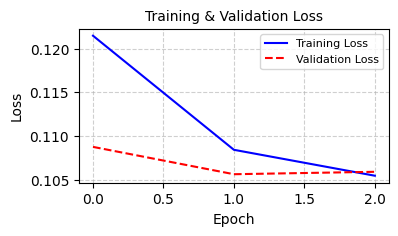

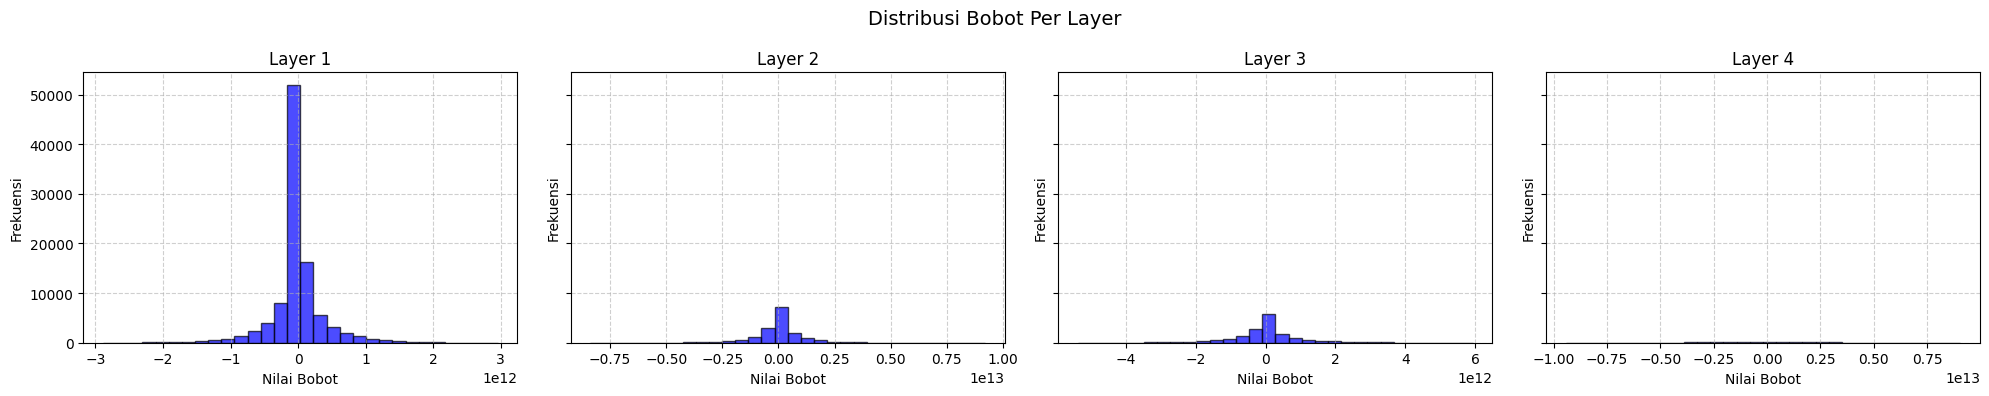

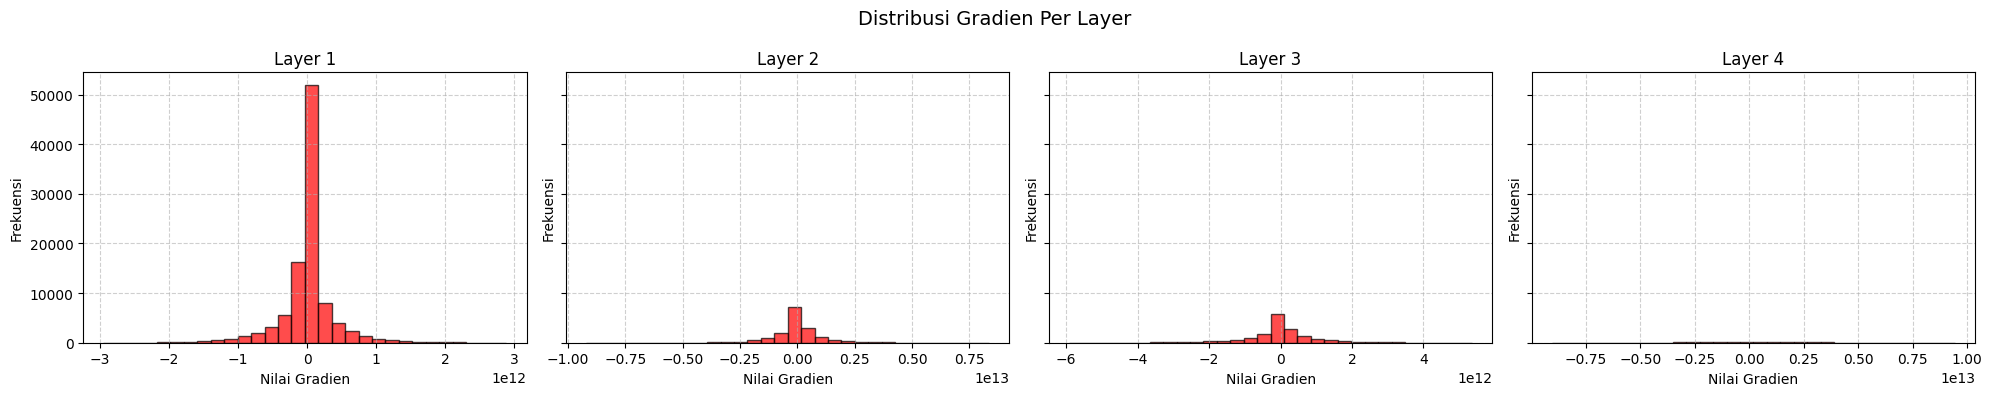


 Depth 6 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1078 - Validation Loss: 0.0932 - 1.83s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.104846  | 0.106997
    2 |  0.107647  | 0.107192
    3 |  0.107848  | 0.093172


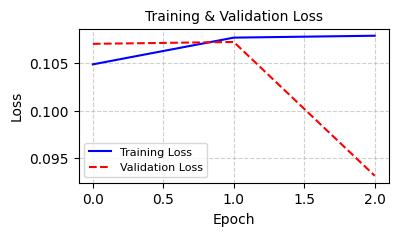

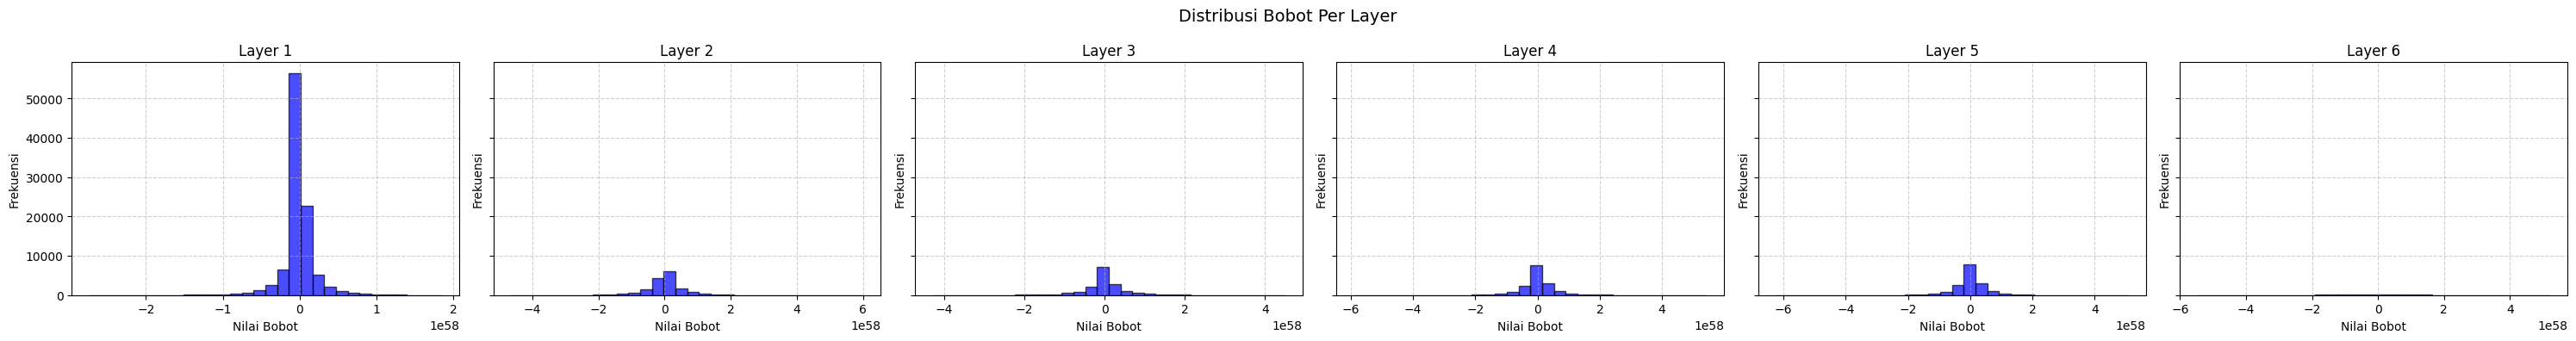

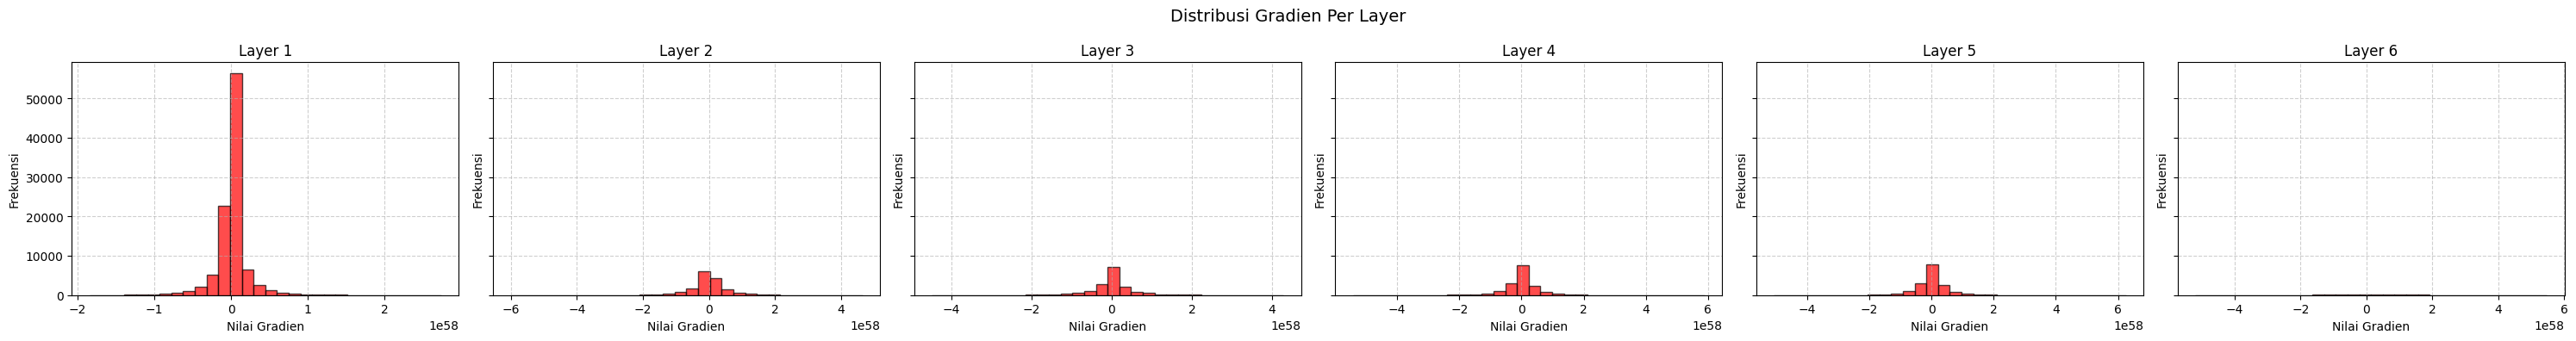

In [8]:
depth_var = [2, 4, 6]

results = {}
for depth in depth_var:
    print(f"\n Depth {depth} Result\n")
    ffnn, acc = train_ffnn(depth=depth, width=128, learning_rate=0.01, activation=linear, weight_init='uniform')
    results[f"Depth {depth}"] = acc

### Pengaruh Learning Rates


 Learning Rate 0.001 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0934 - Validation Loss: 0.0947 - 1.47s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.117144  | 0.122898
    2 |  0.123471  | 0.093847
    3 |  0.093431  | 0.094657


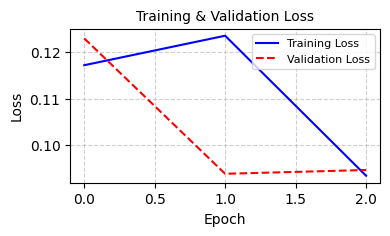

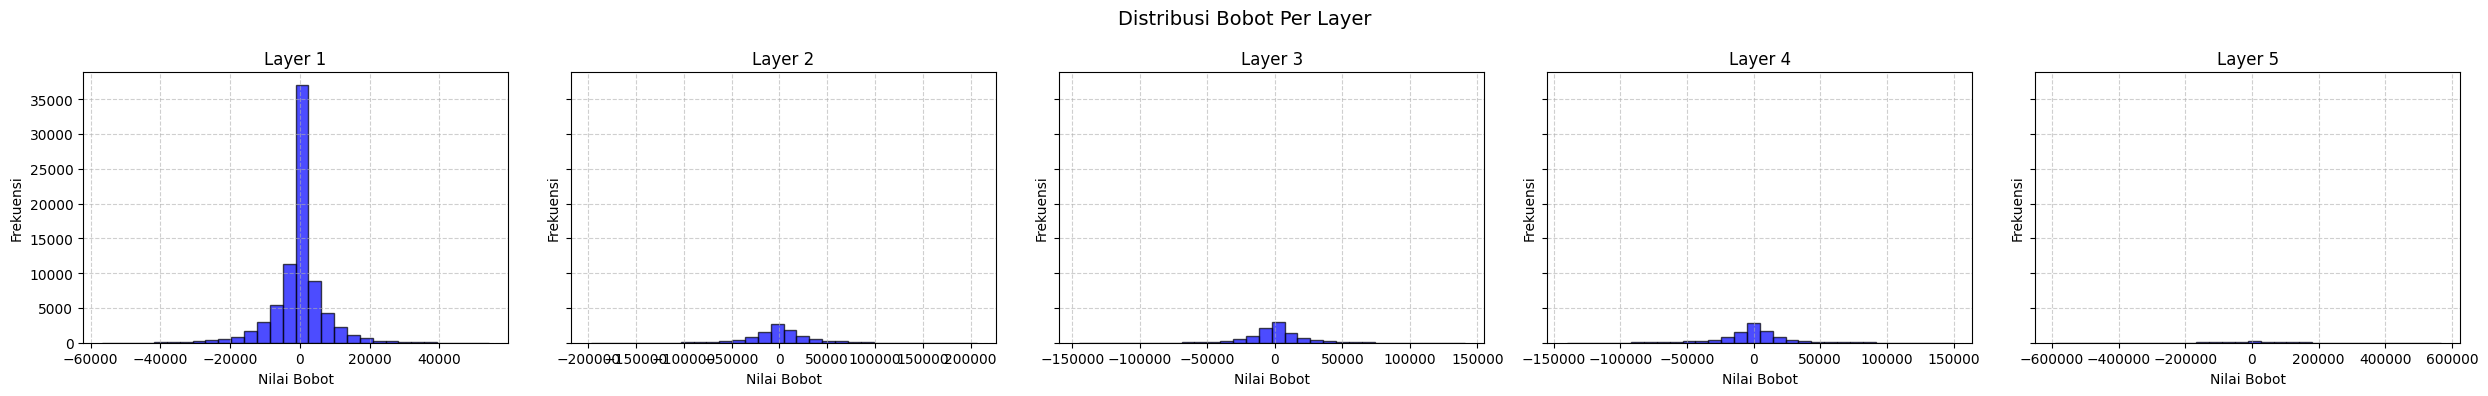

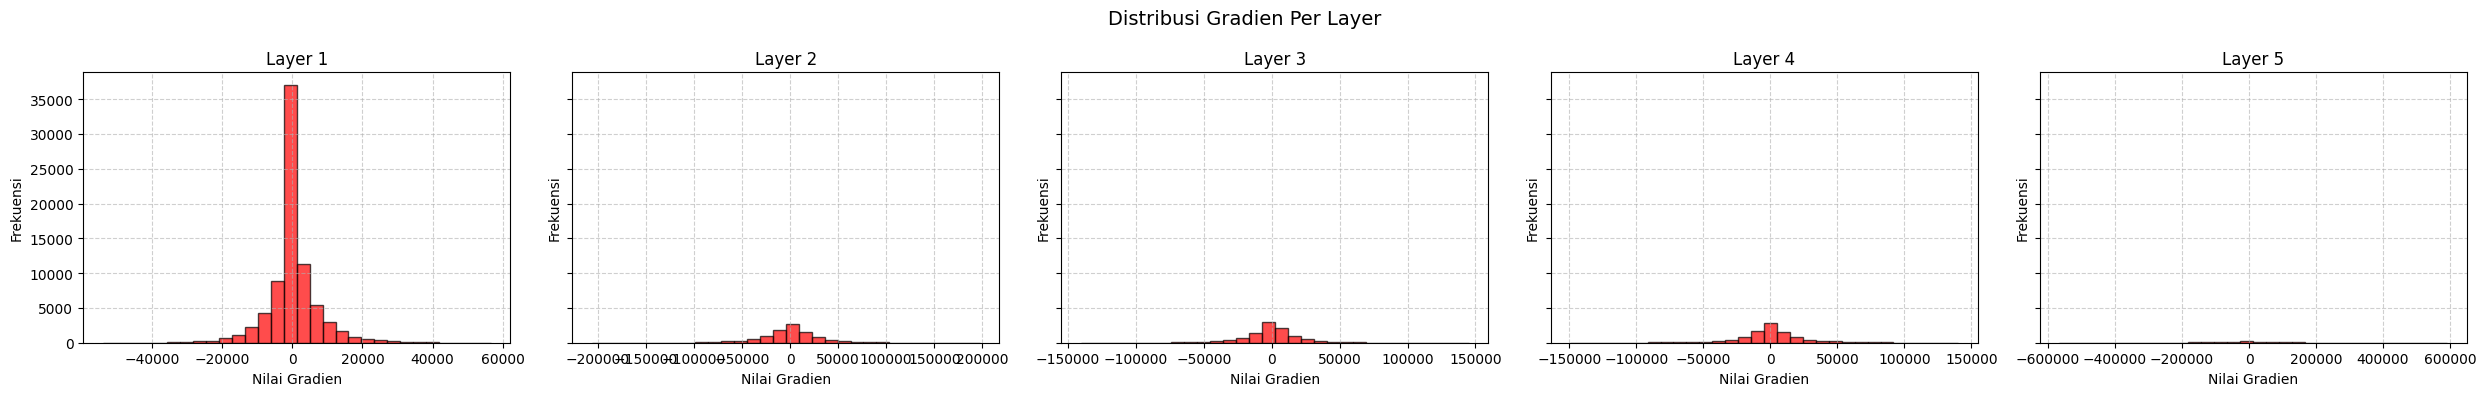


 Learning Rate 0.01 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0981 - Validation Loss: 0.0980 - 1.45s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.117144  | 0.087319
    2 |  0.087513  | 0.098033
    3 |  0.098096  | 0.098014


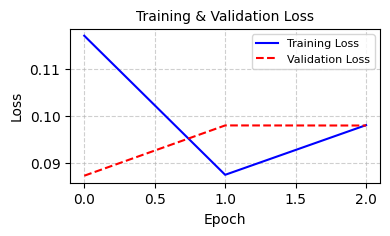

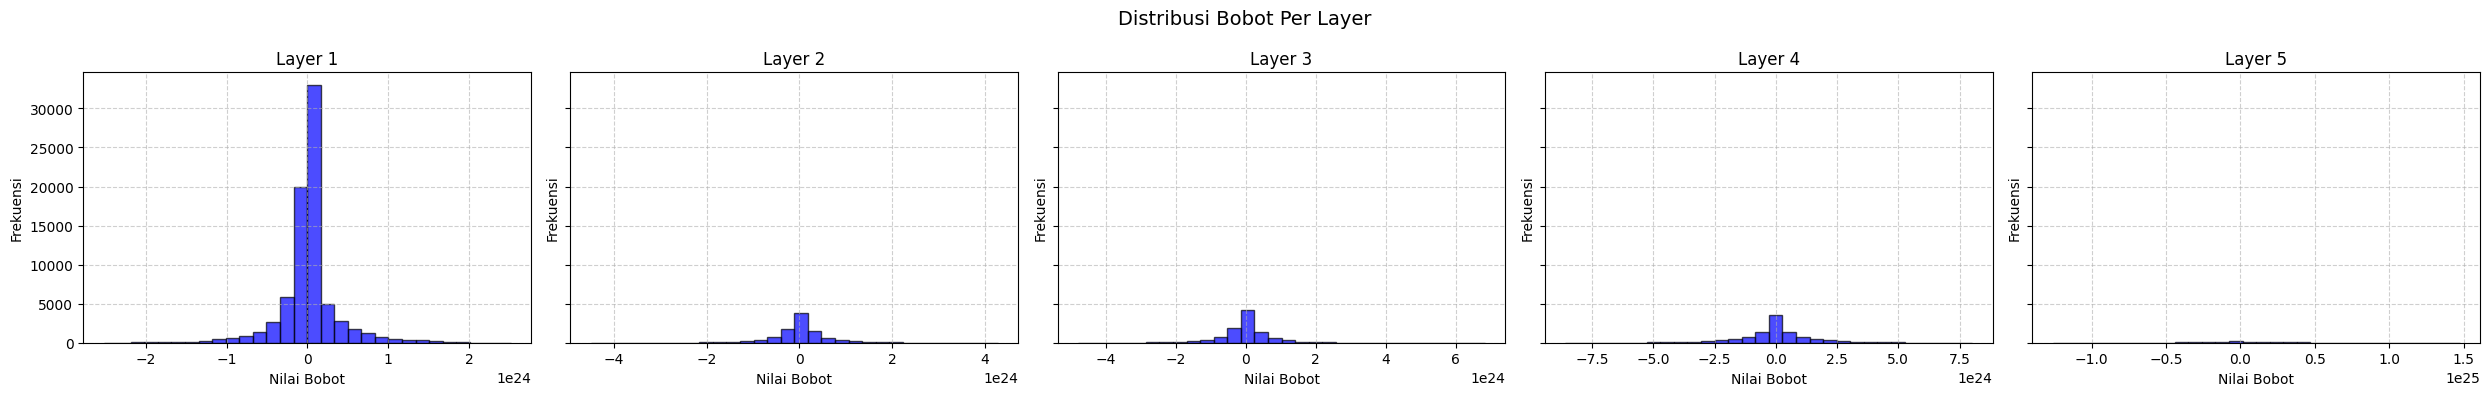

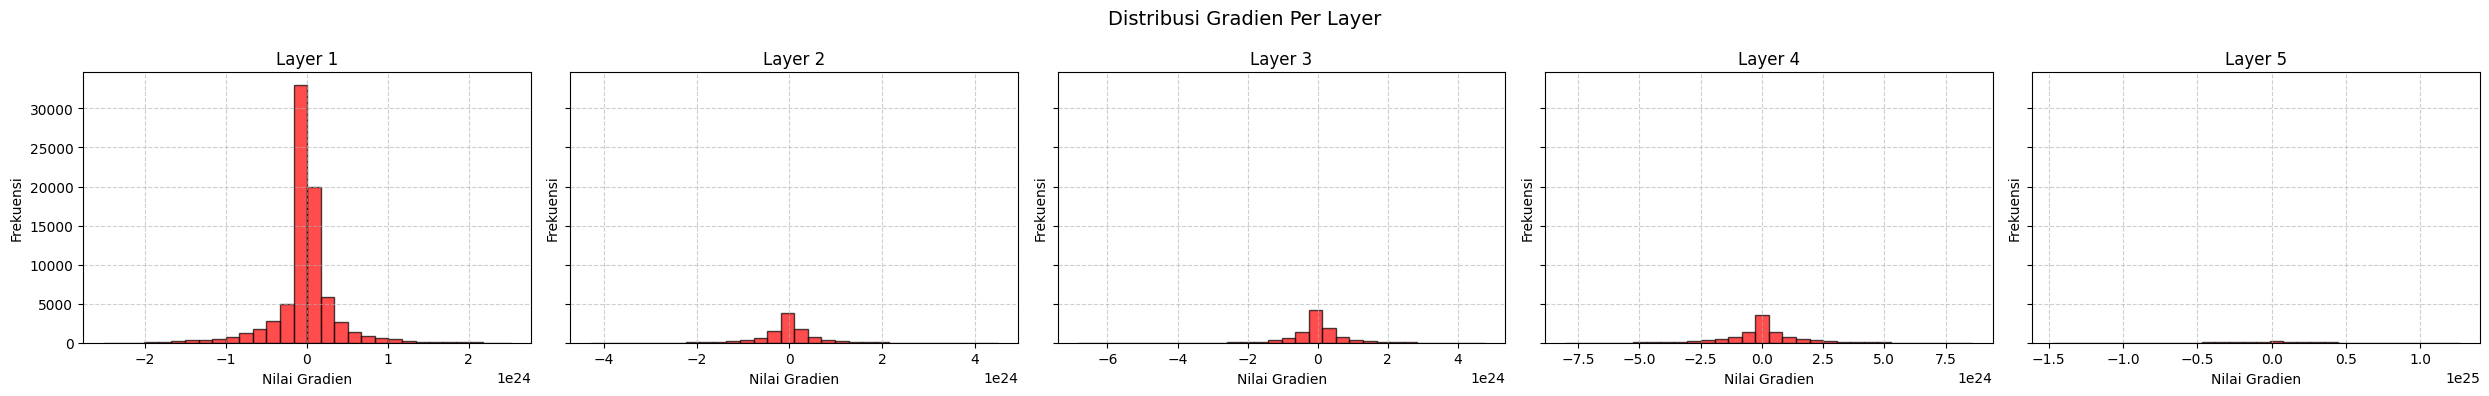


 Learning Rate 0.1 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0977 - Validation Loss: 0.0984 - 1.48s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.117144  | 0.086903
    2 |  0.087049  | 0.097773
    3 |  0.097746  | 0.098381


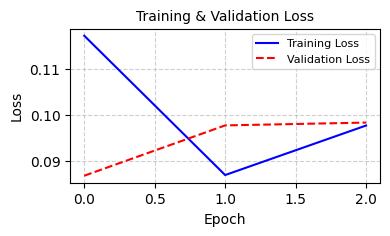

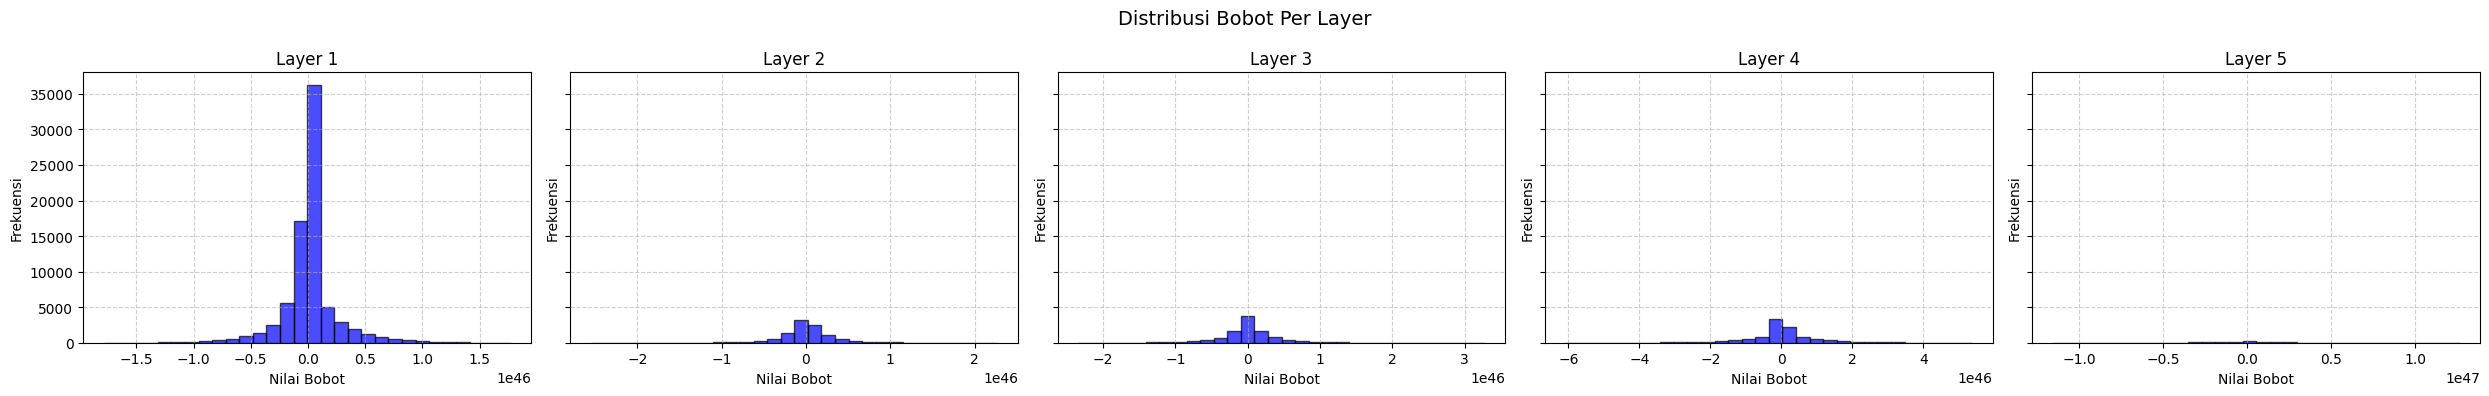

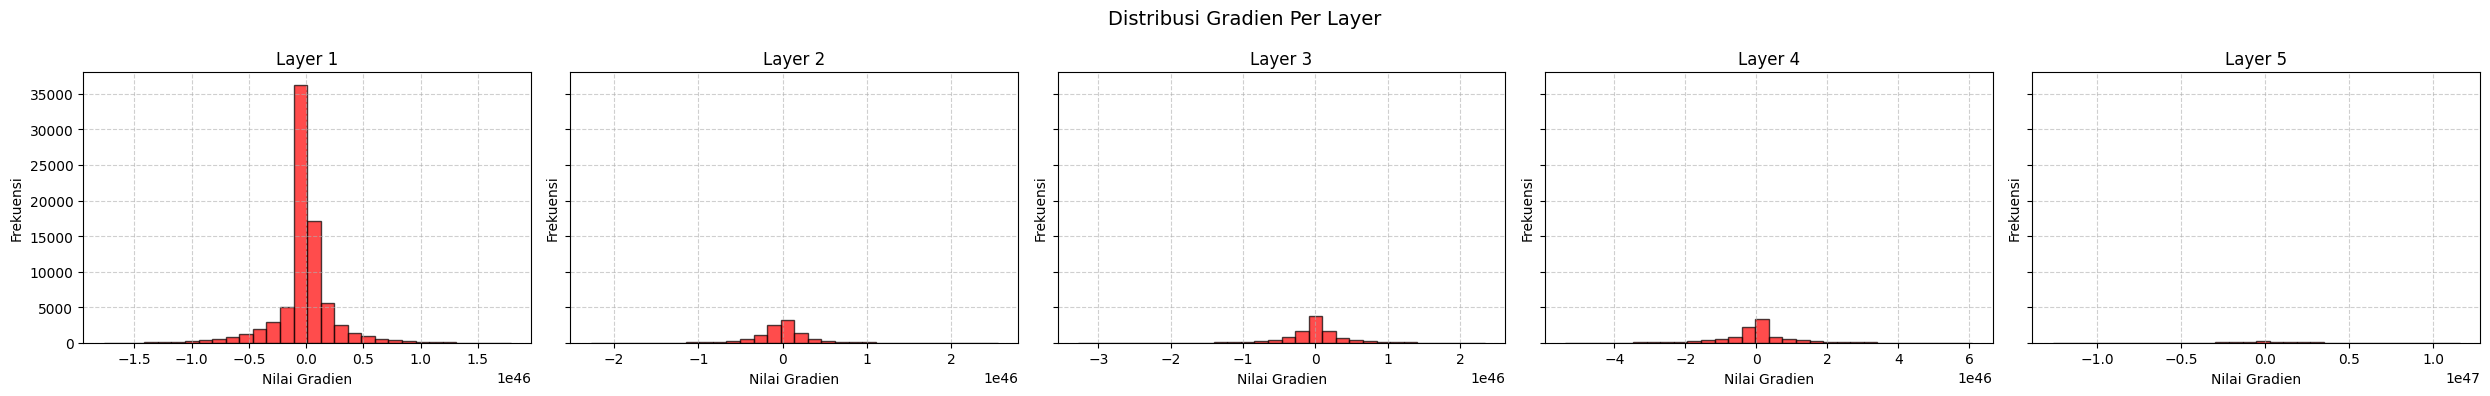

In [9]:
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f"\n Learning Rate {lr} Result\n")
    ffnn, acc = train_ffnn(depth=5, width=100, learning_rate=lr, activation=linear, weight_init='uniform')
    results[f"LR {lr}"] = acc

### Pengaruh Inisialisasi Bobot


 zero weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0900 - Validation Loss: 0.0900 - 1.45s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.090000  | 0.089996
    2 |  0.089994  | 0.089993
    3 |  0.089989  | 0.089990


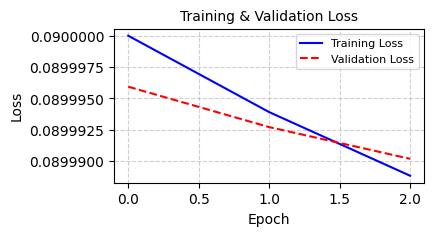

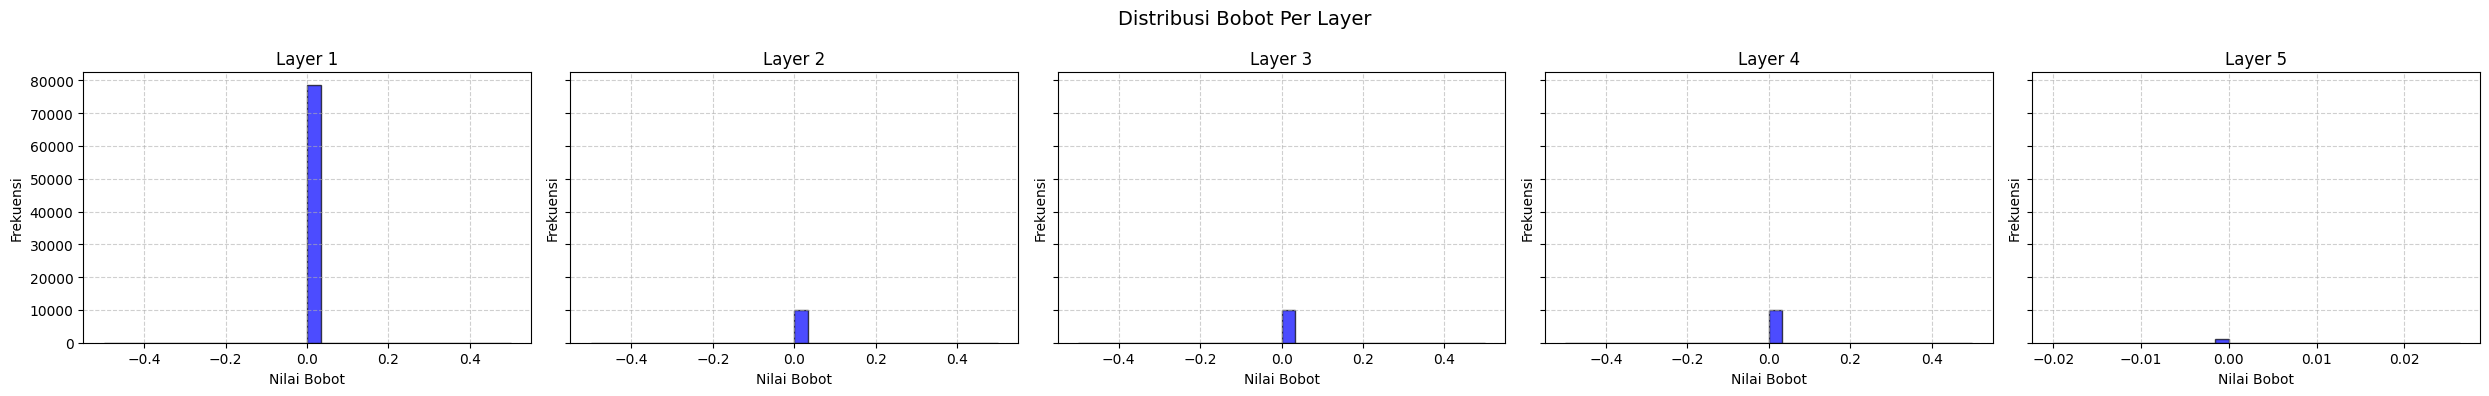

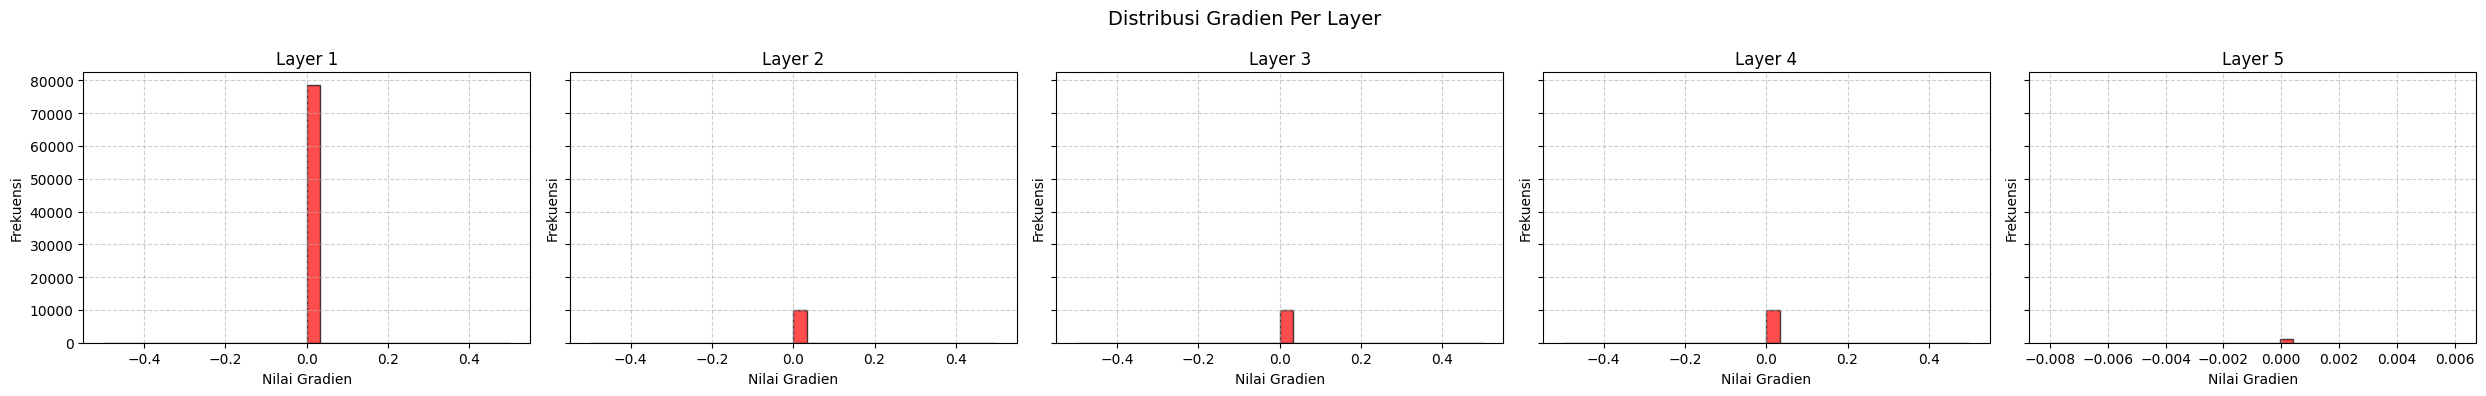


 normal weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1006 - Validation Loss: 0.0962 - 1.83s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.101662  | 0.090424
    2 |  0.090313  | 0.099907
    3 |  0.100622  | 0.096236


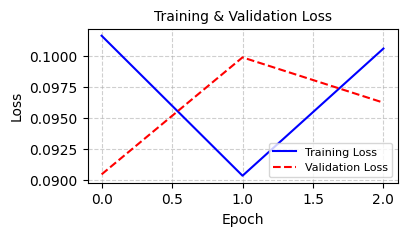

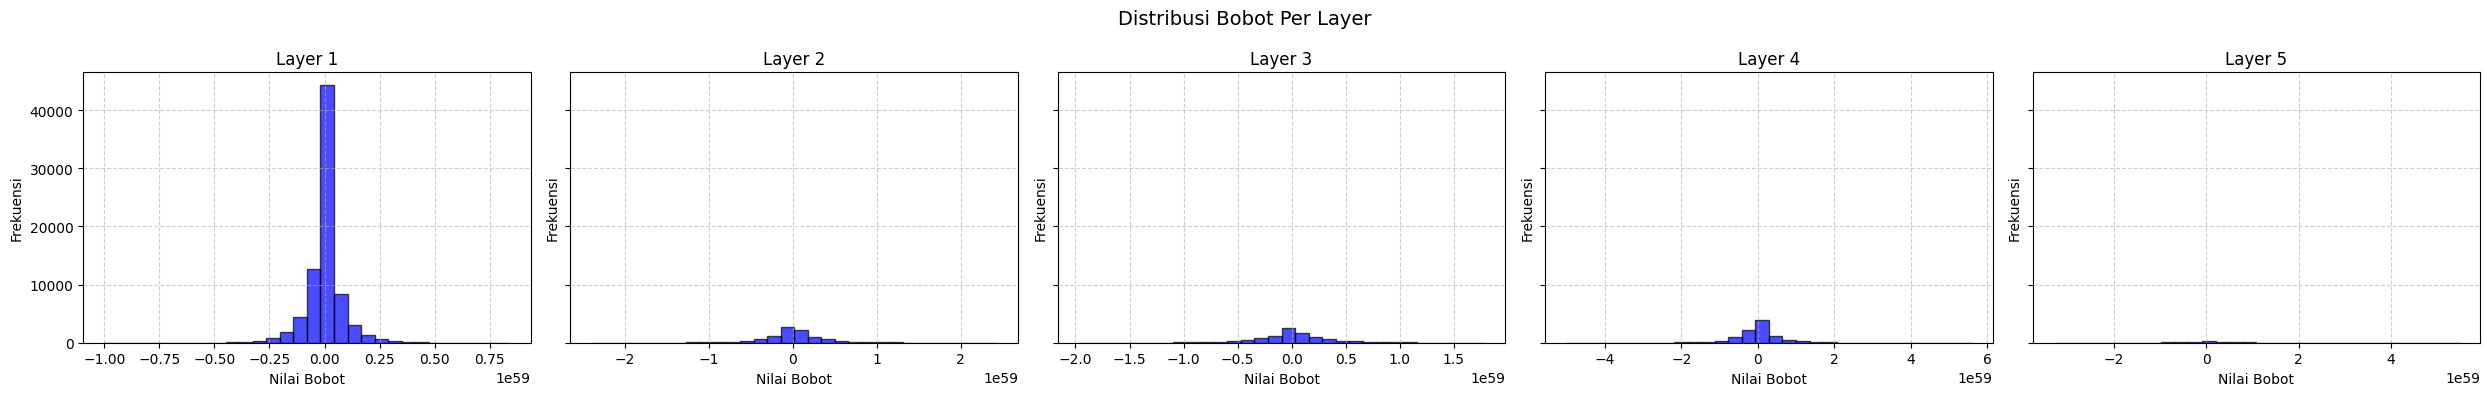

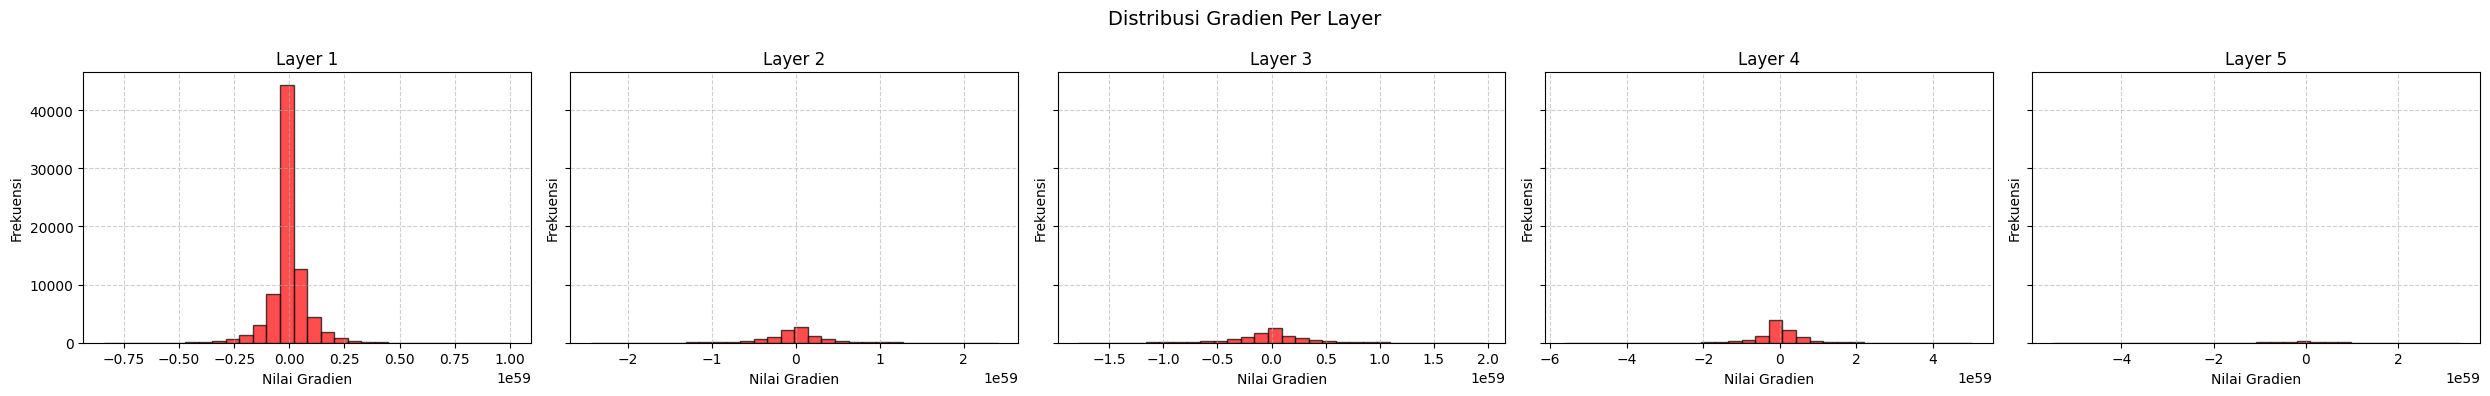


 uniform weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0981 - Validation Loss: 0.0980 - 2.09s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.117144  | 0.087319
    2 |  0.087513  | 0.098033
    3 |  0.098096  | 0.098014


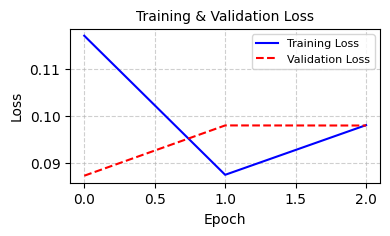

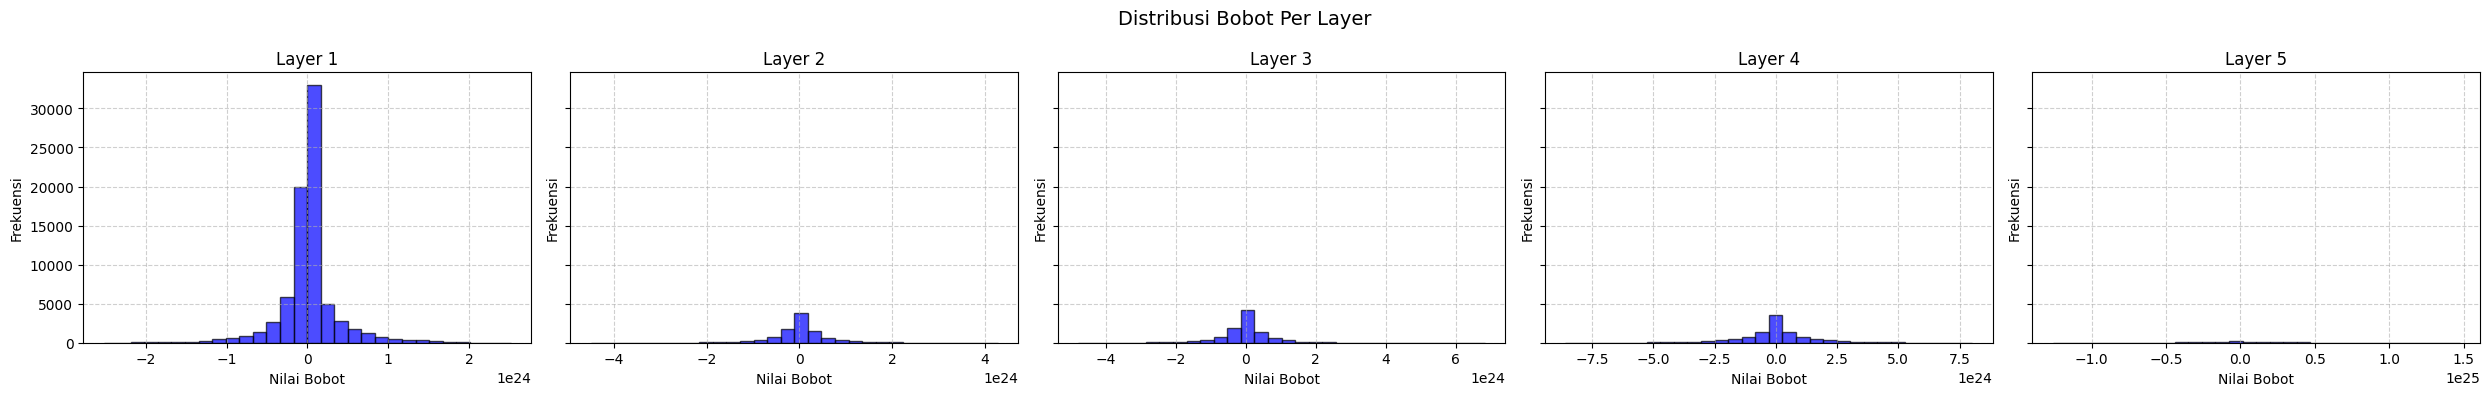

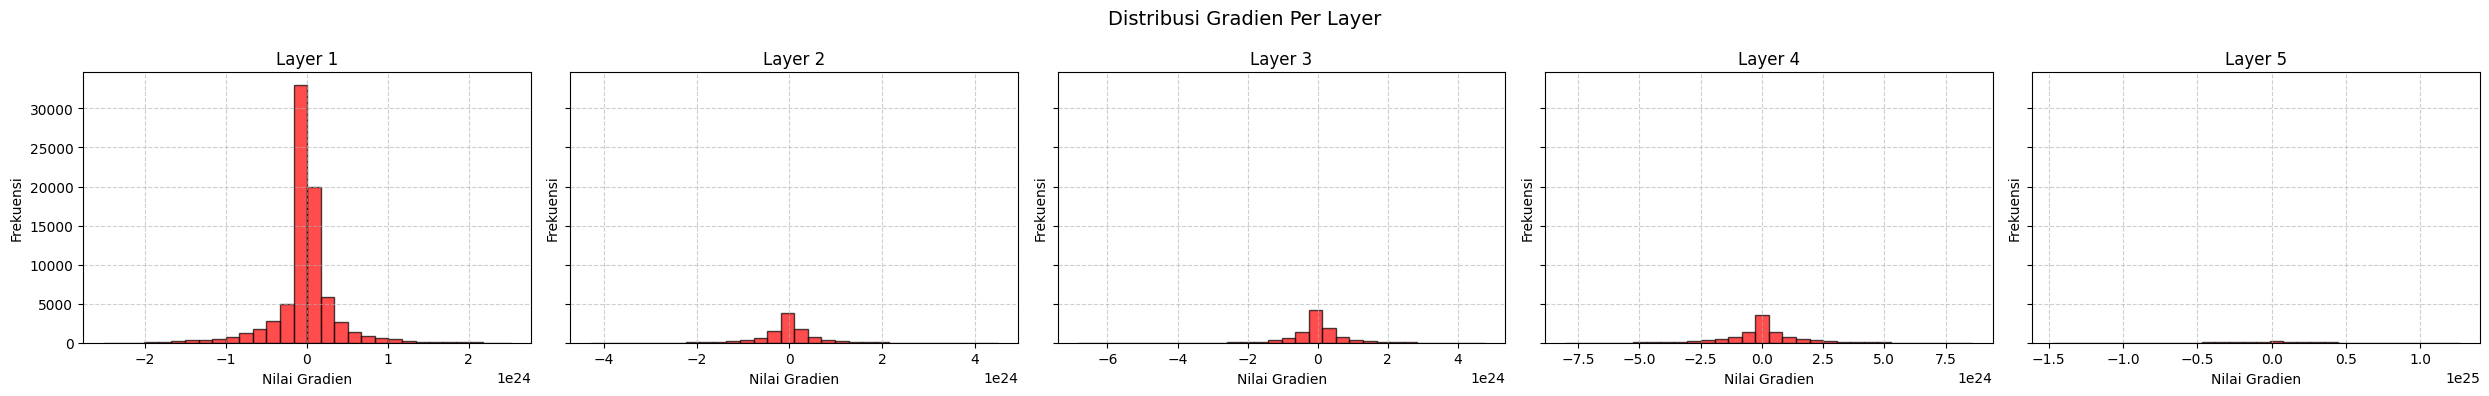


 xavier weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1351 - Validation Loss: 0.0989 - 1.82s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.106465  | 0.148123
    2 |  0.146456  | 0.135219
    3 |  0.135145  | 0.098950


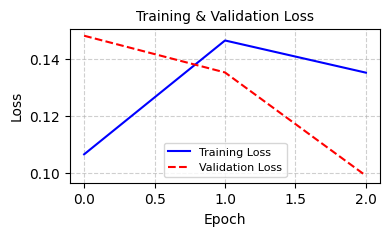

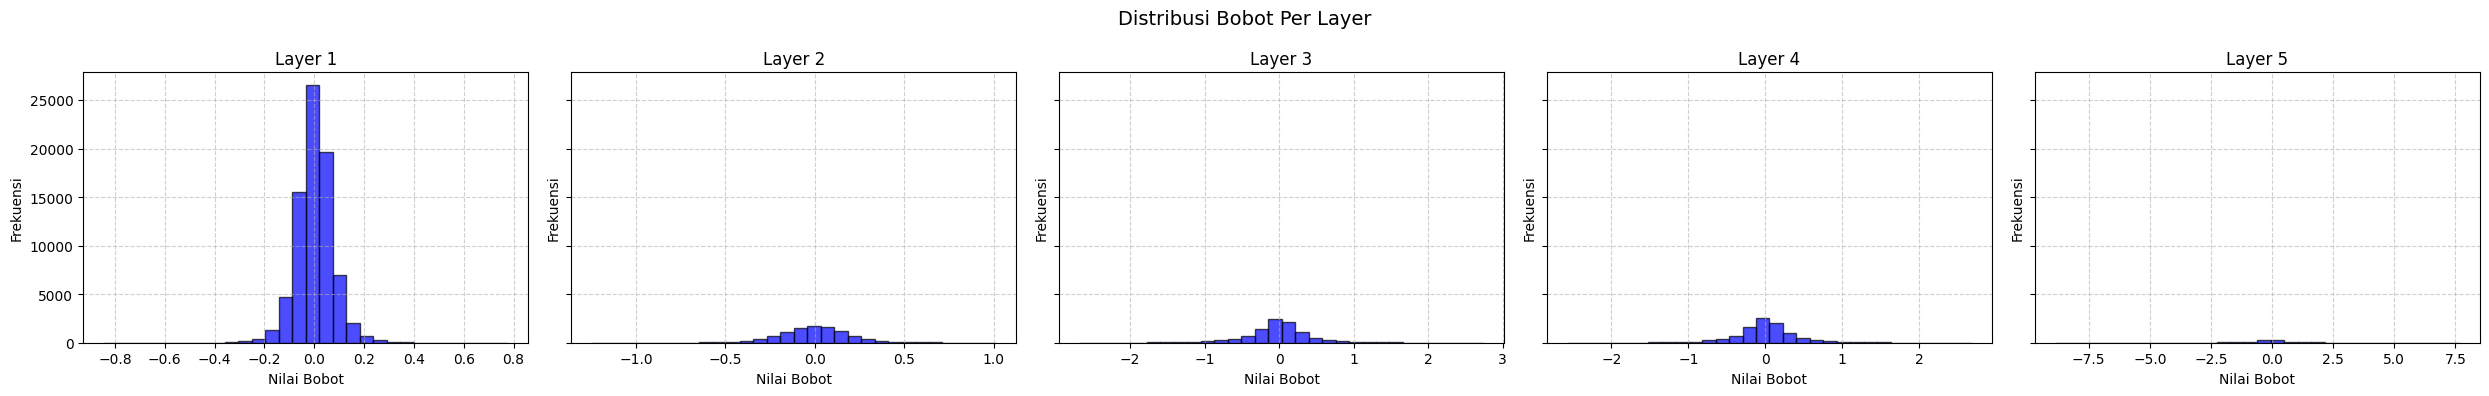

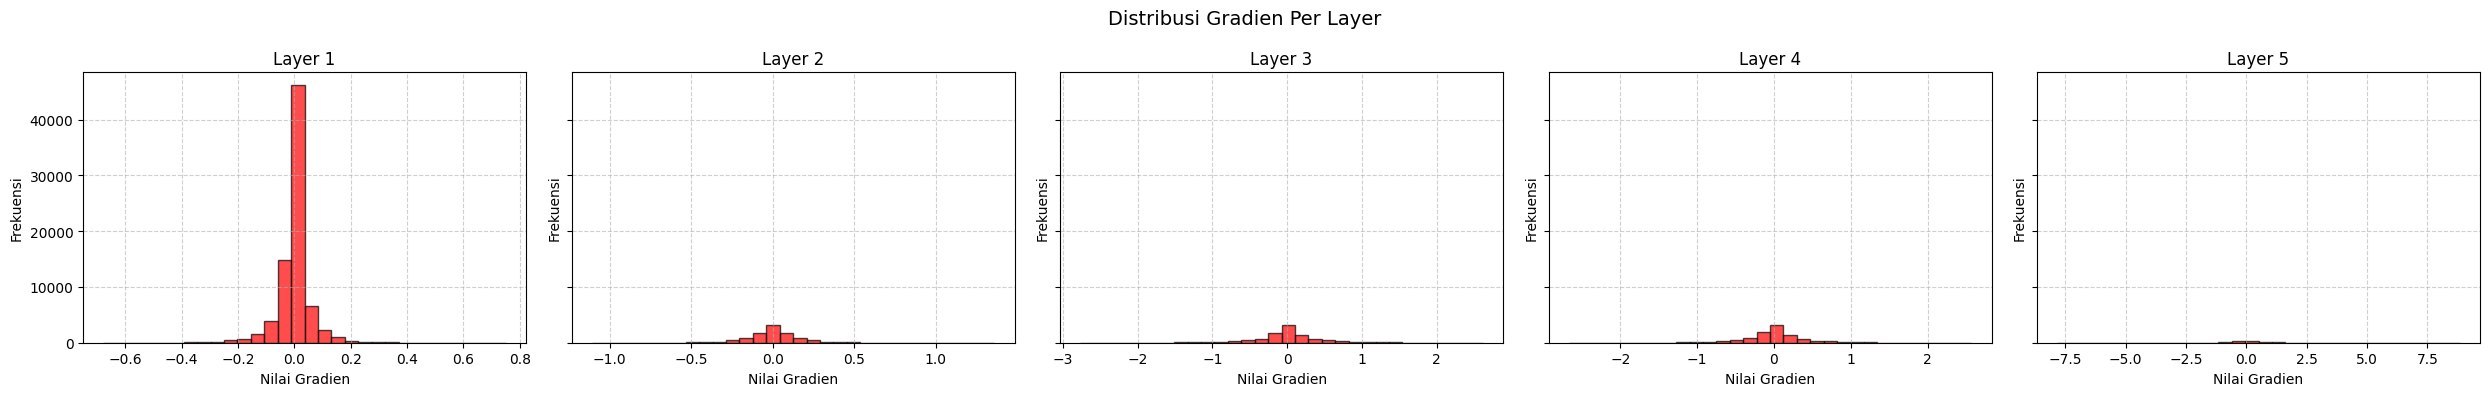


 he weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1417 - Validation Loss: 0.1001 - 1.47s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.144060  | 0.183153
    2 |  0.182961  | 0.140990
    3 |  0.141676  | 0.100067


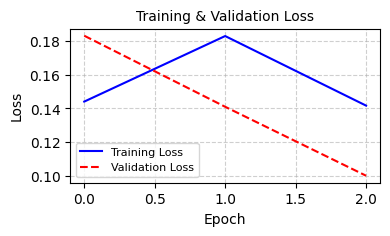

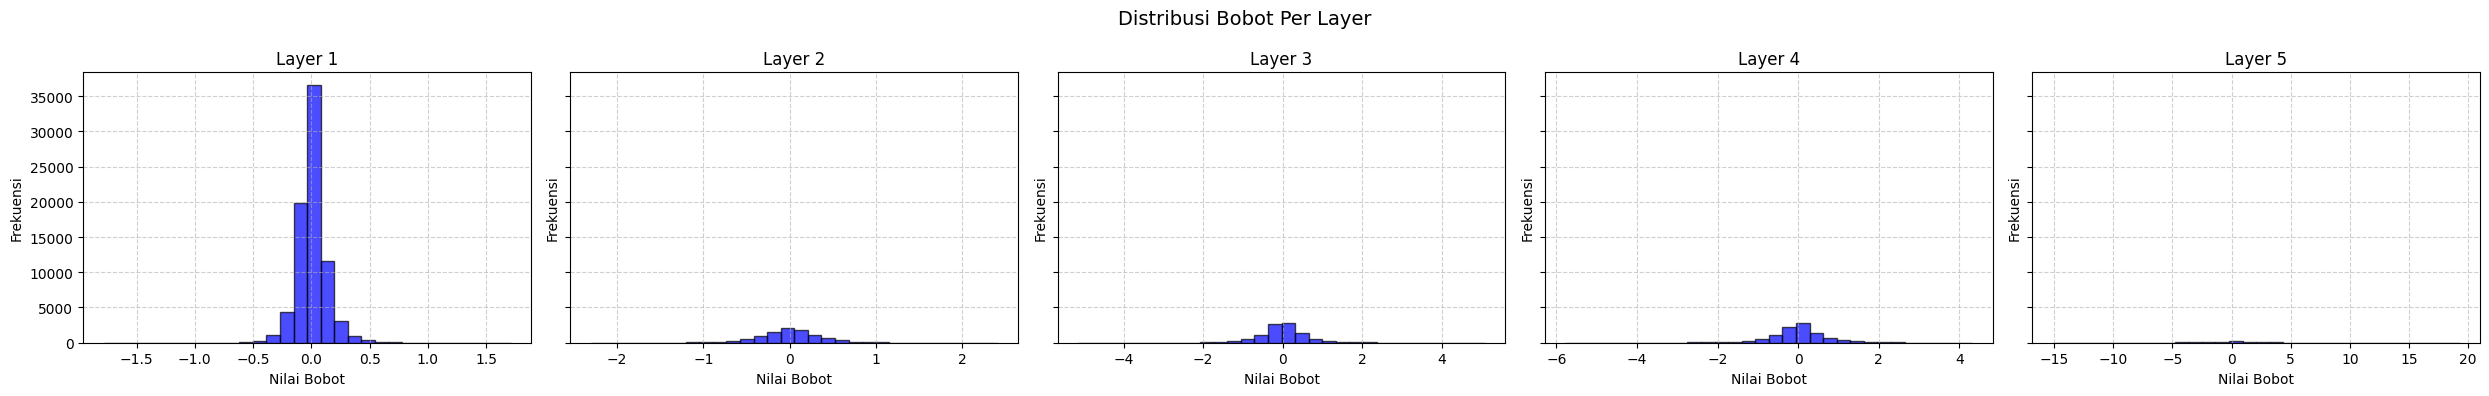

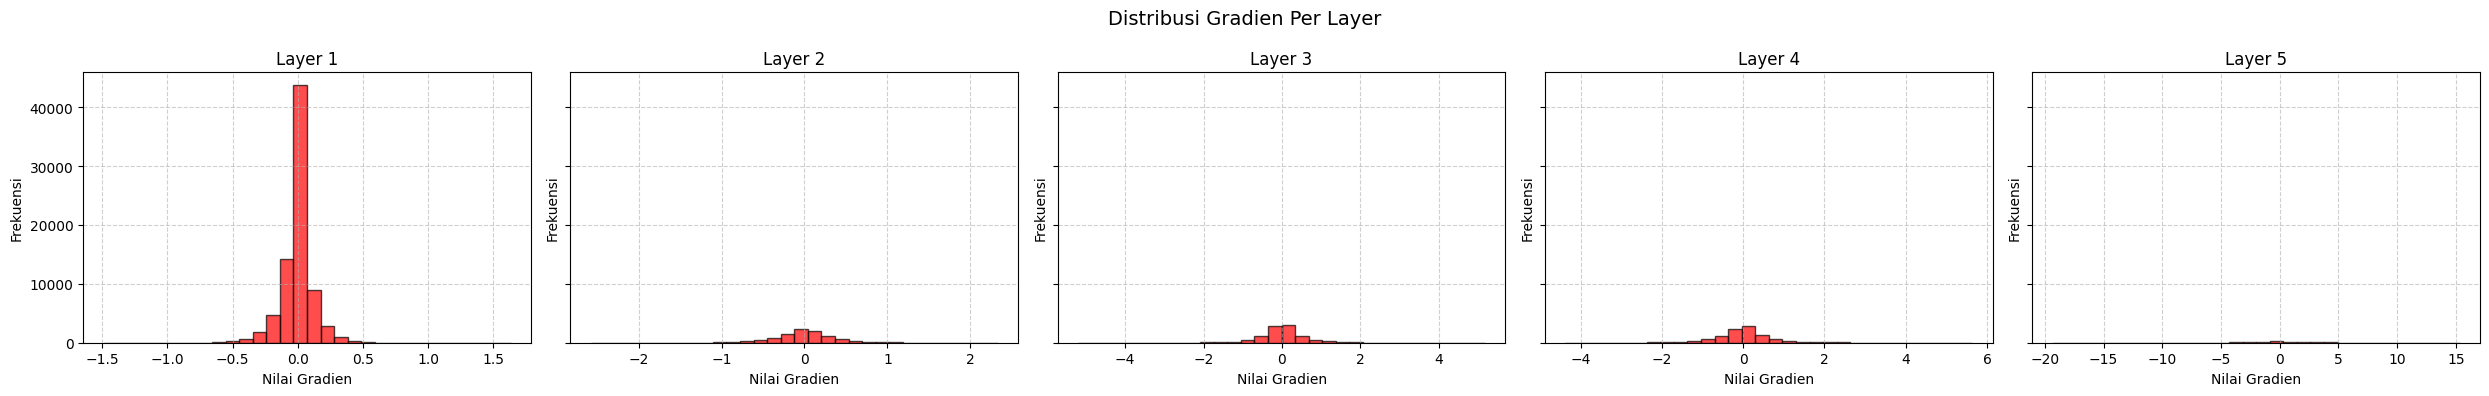

In [10]:
weight_initializations = ['zero','normal', 'uniform','xavier', 'he']

for init in weight_initializations:
    print(f"\n {init} weight initializations Result\n")
    ffnn, acc = train_ffnn(depth=5, width=100, learning_rate=0.01, activation=linear, weight_init=init)
    results[f"Weight Init {init}"] = acc

### Pengaruh Fungsi Aktivasi


 tanh activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0854 - Validation Loss: 0.0953 - 1.72s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.128709  | 0.080335
    2 |  0.079866  | 0.084276
    3 |  0.085448  | 0.095256


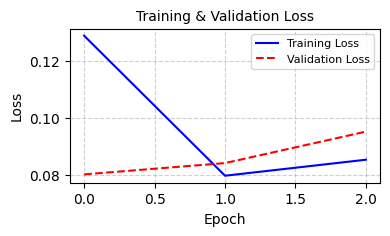

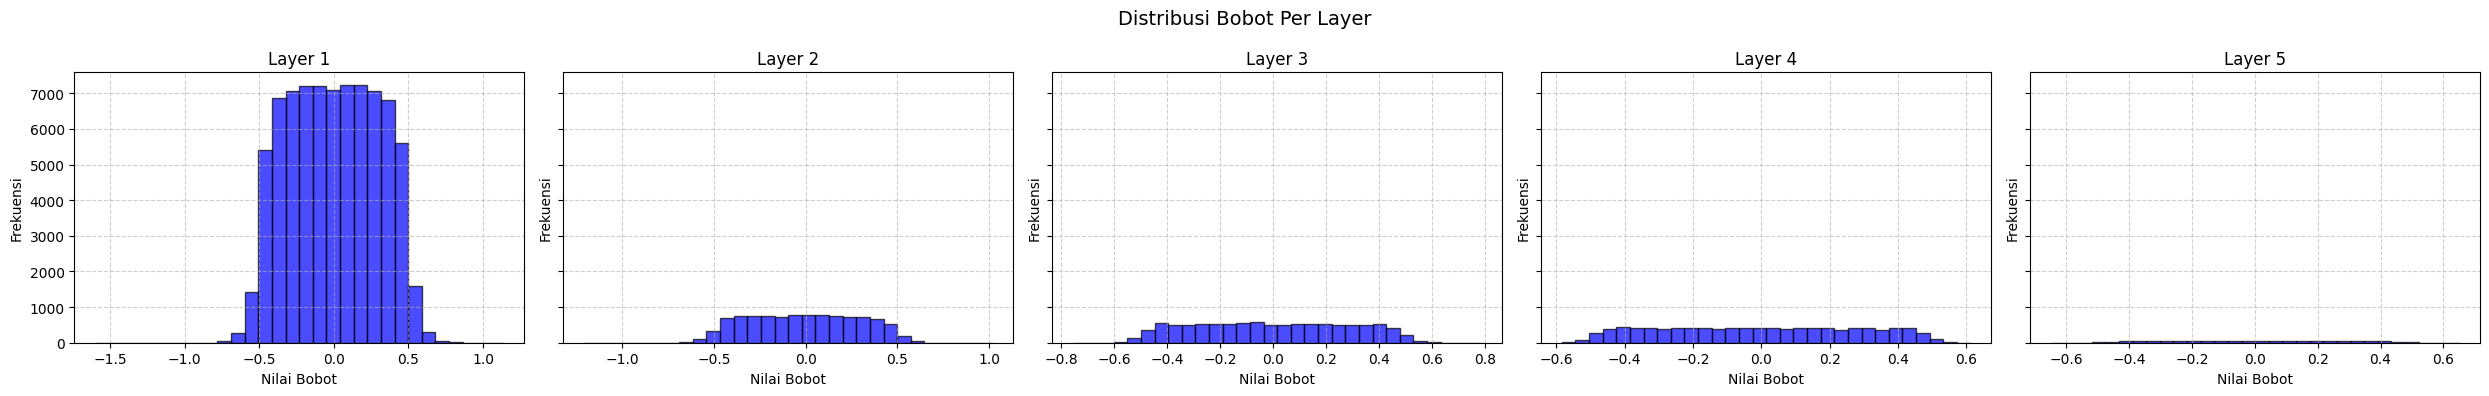

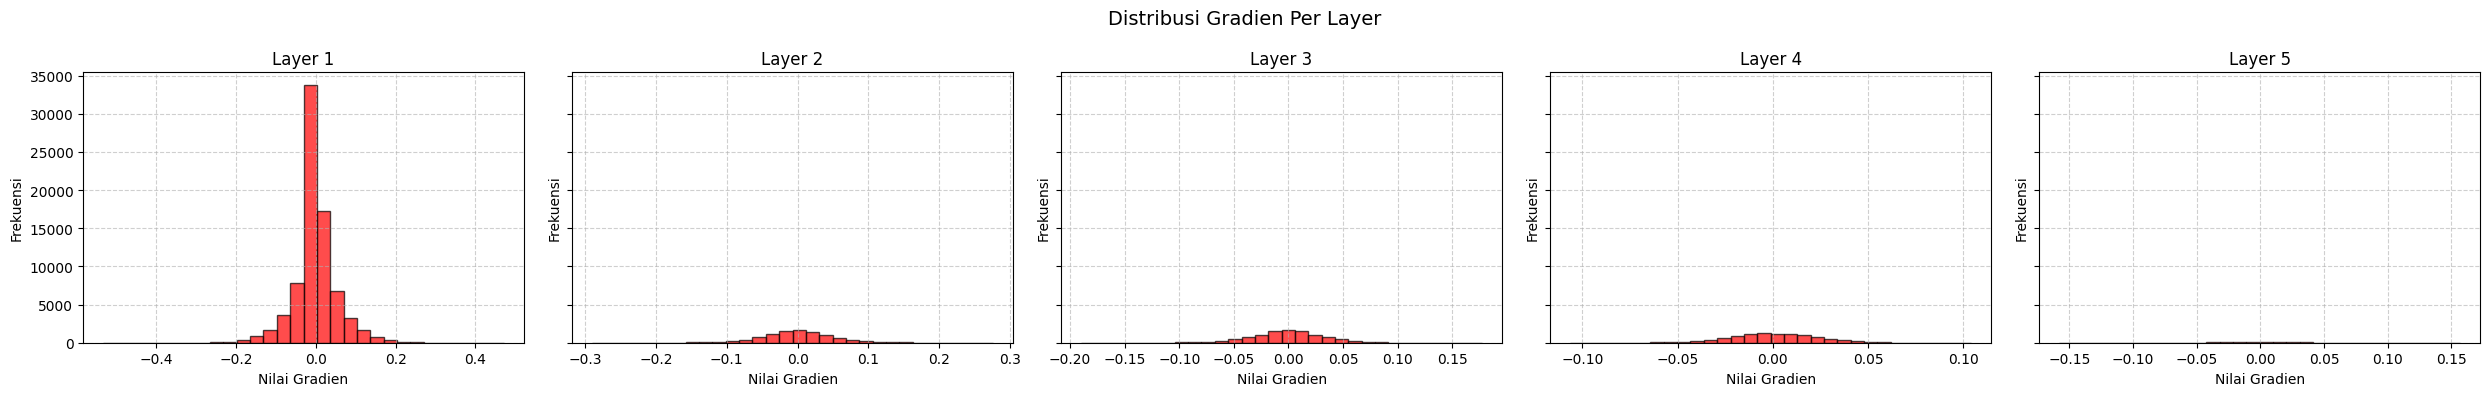


 sigmoid activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1158 - Validation Loss: 0.1141 - 1.62s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.111189  | 0.099765
    2 |  0.099579  | 0.116372
    3 |  0.115849  | 0.114095


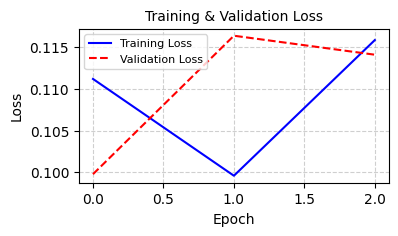

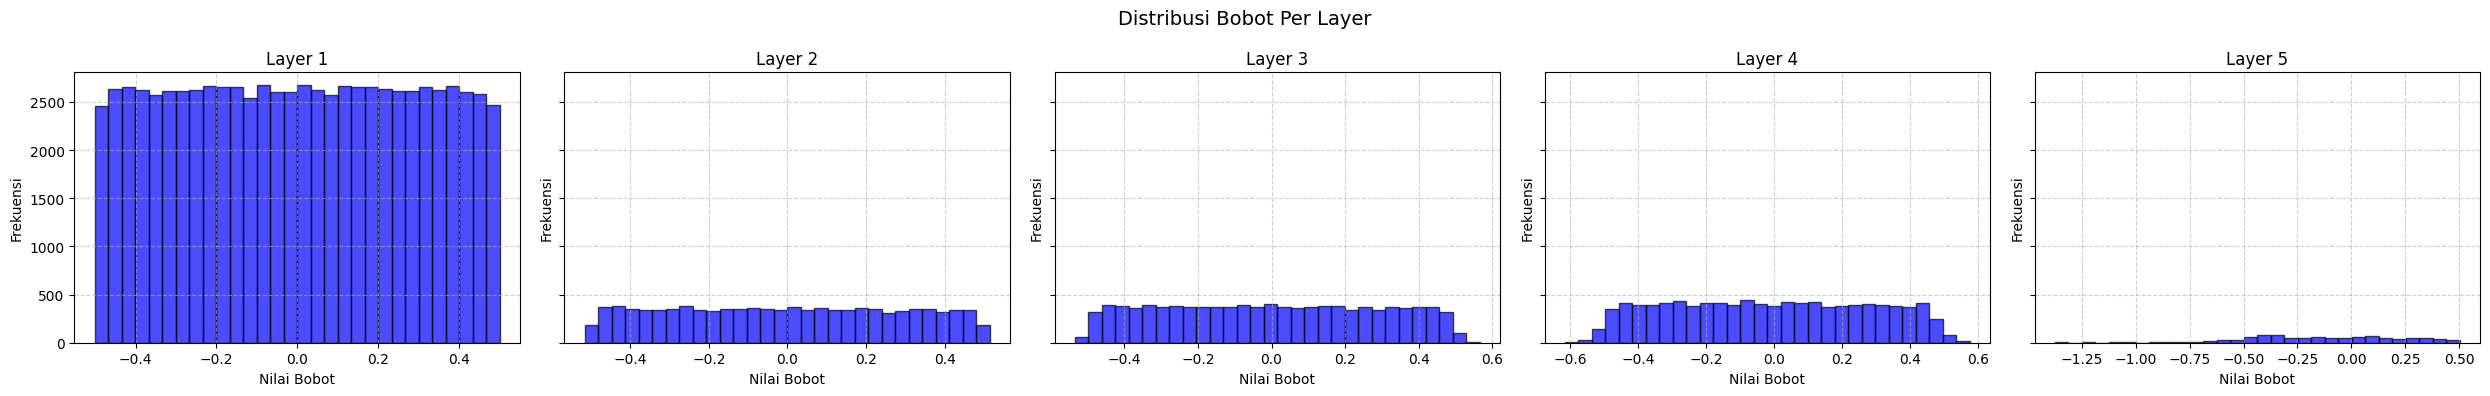

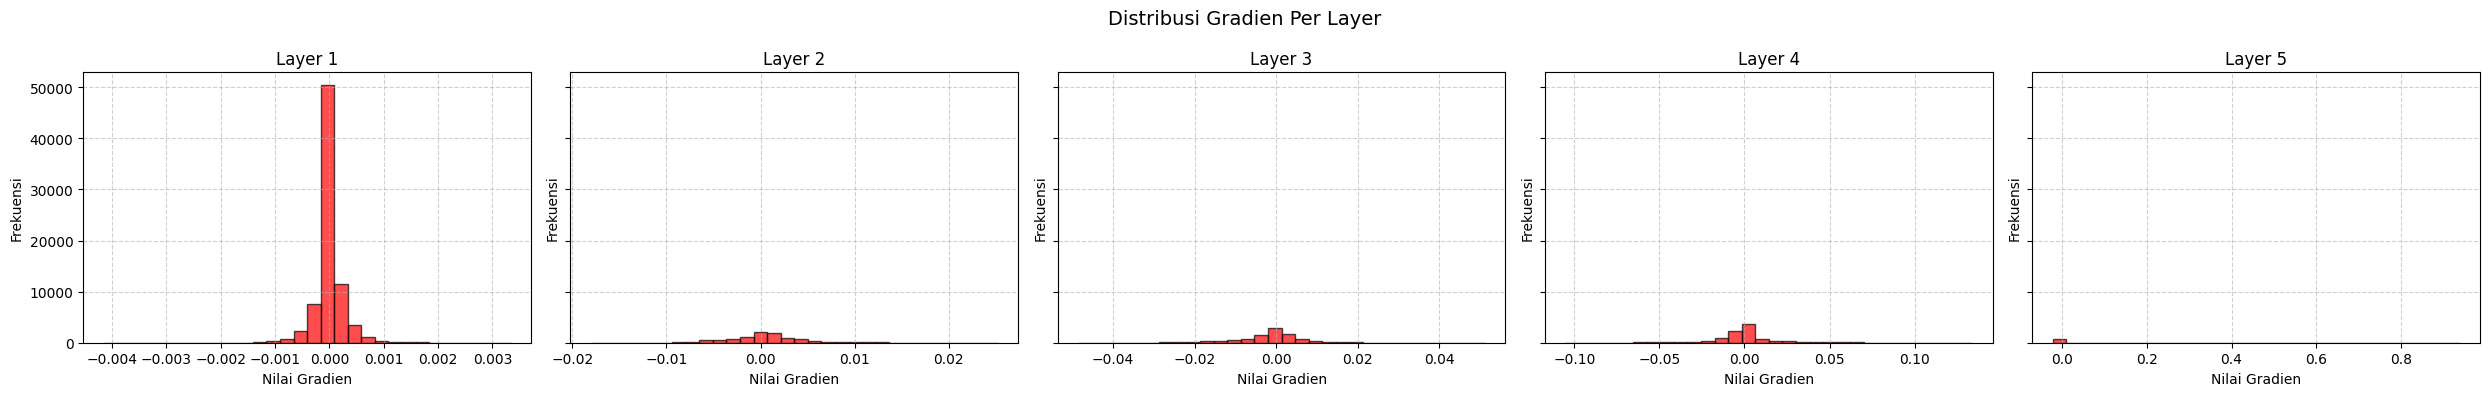


 relu activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1781 - Validation Loss: 0.1790 - 1.54s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.170665  | 0.178960
    2 |  0.178080  | 0.178960
    3 |  0.178080  | 0.178960


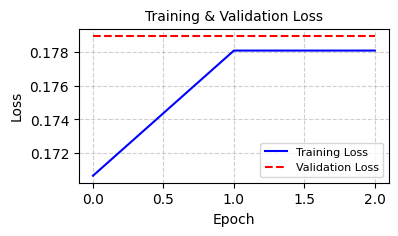

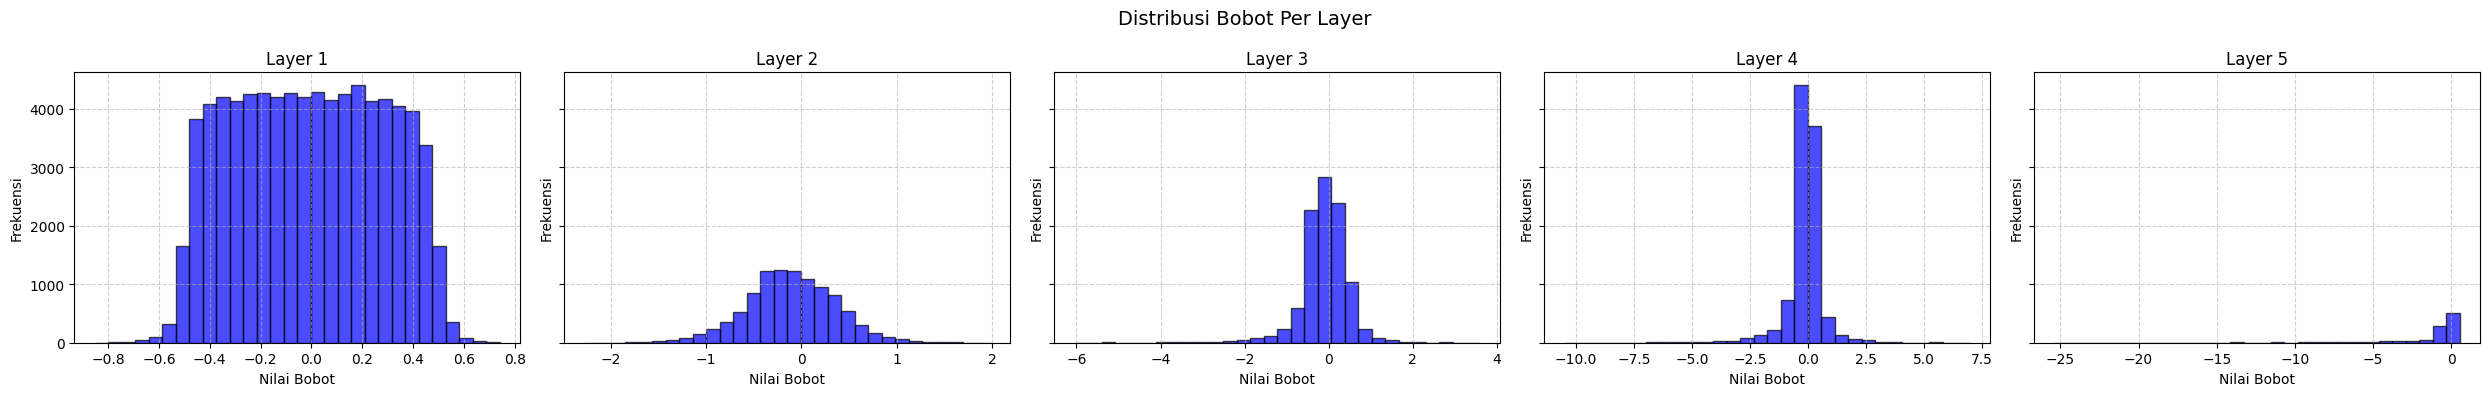

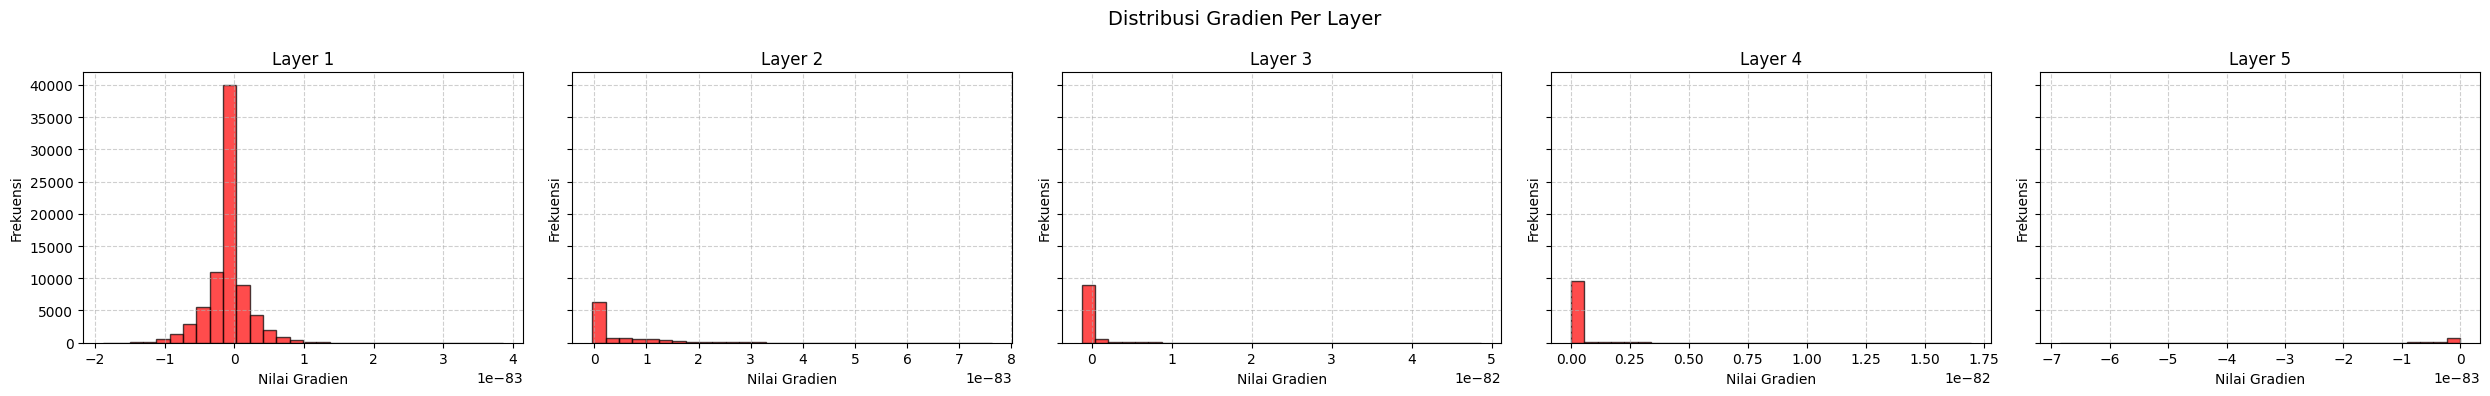


 linear activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0981 - Validation Loss: 0.0980 - 2.05s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.117144  | 0.087319
    2 |  0.087513  | 0.098033
    3 |  0.098096  | 0.098014


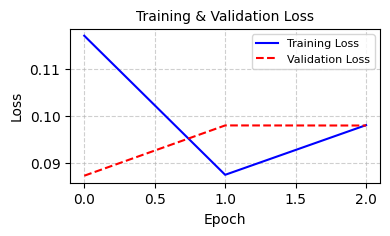

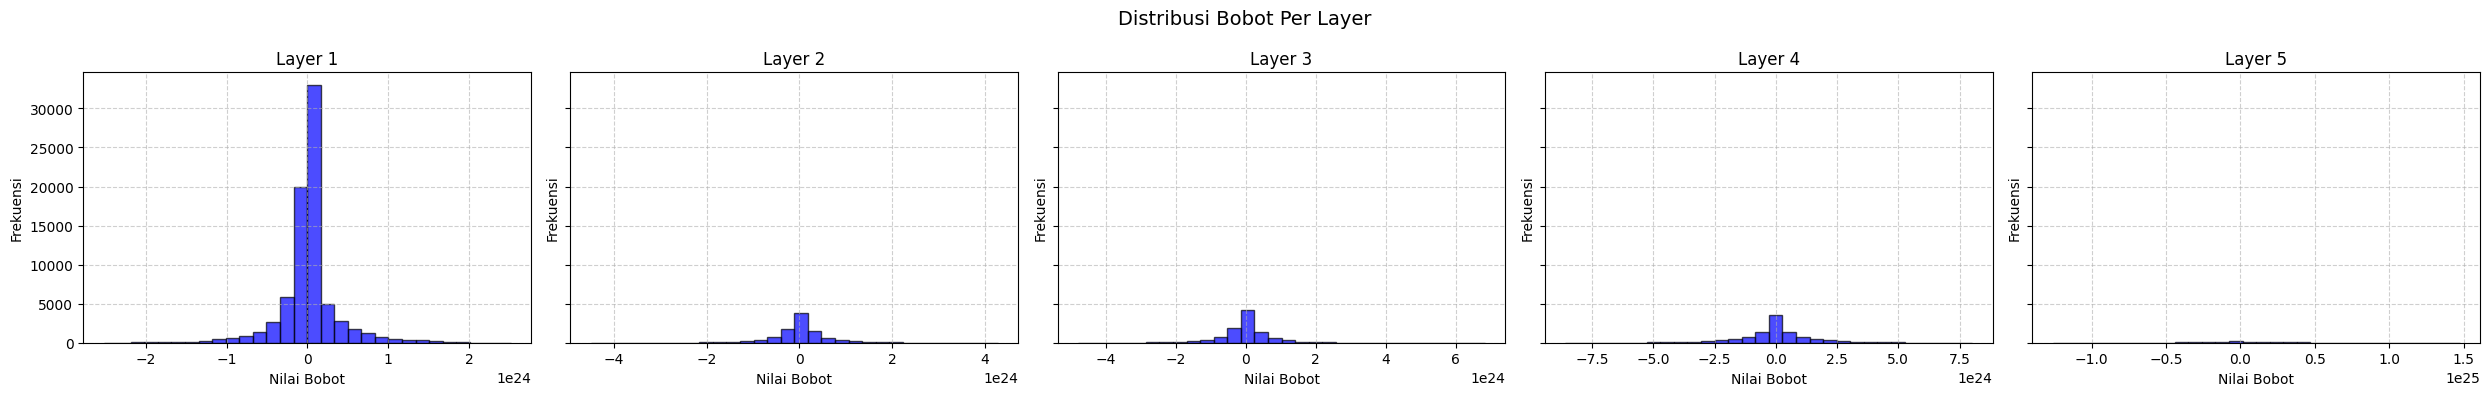

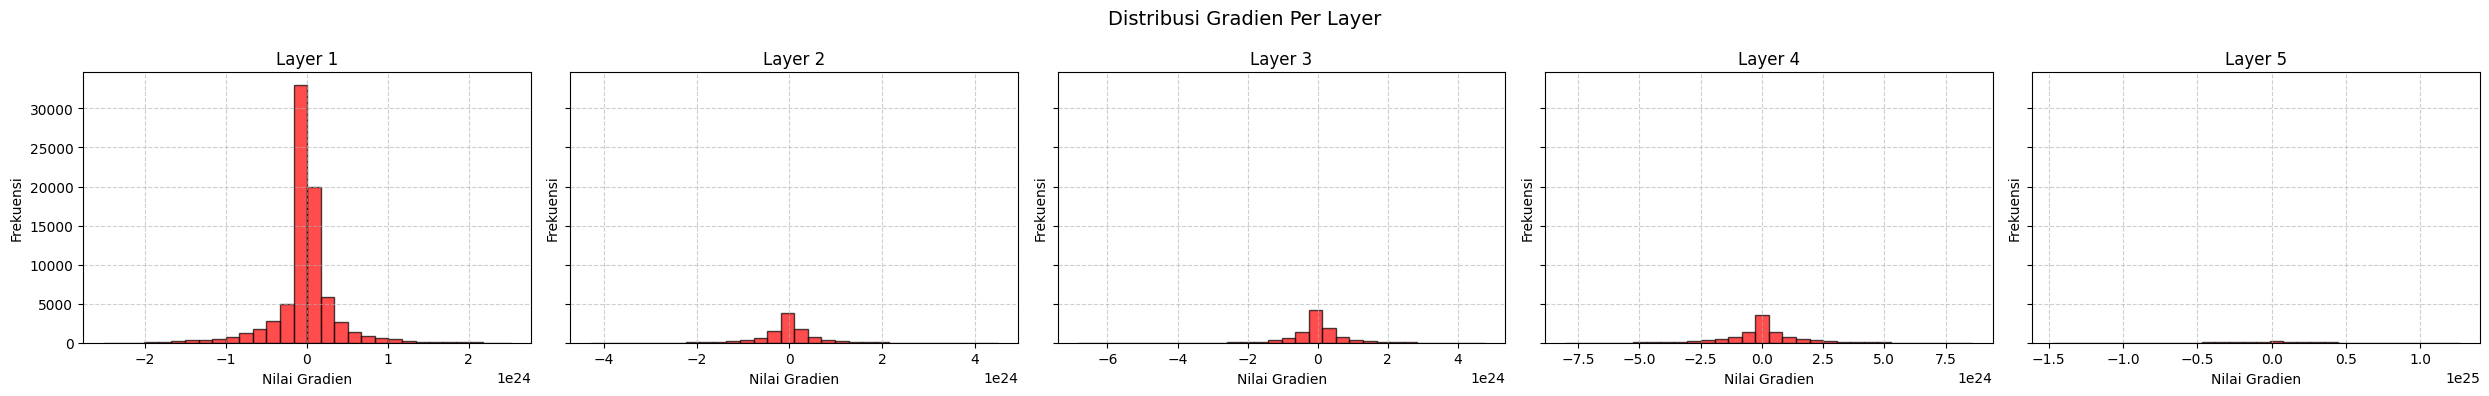

In [11]:
activations = [tanh, sigmoid, relu, linear]

for activation in activations:
    print(f"\n {activation.__name__} activation Result\n")
    ffnn, acc = train_ffnn(depth=5, width=100, learning_rate=0.01, activation=activation, weight_init='uniform')
    results[f"Activation {activation.__name__}"] = acc


### Perbandingan dengan MLP

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1781 - Validation Loss: 0.1790 - 1.40s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.098967  | 0.178960
    2 |  0.178080  | 0.178960
    3 |  0.178080  | 0.178960


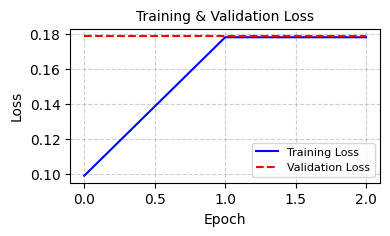

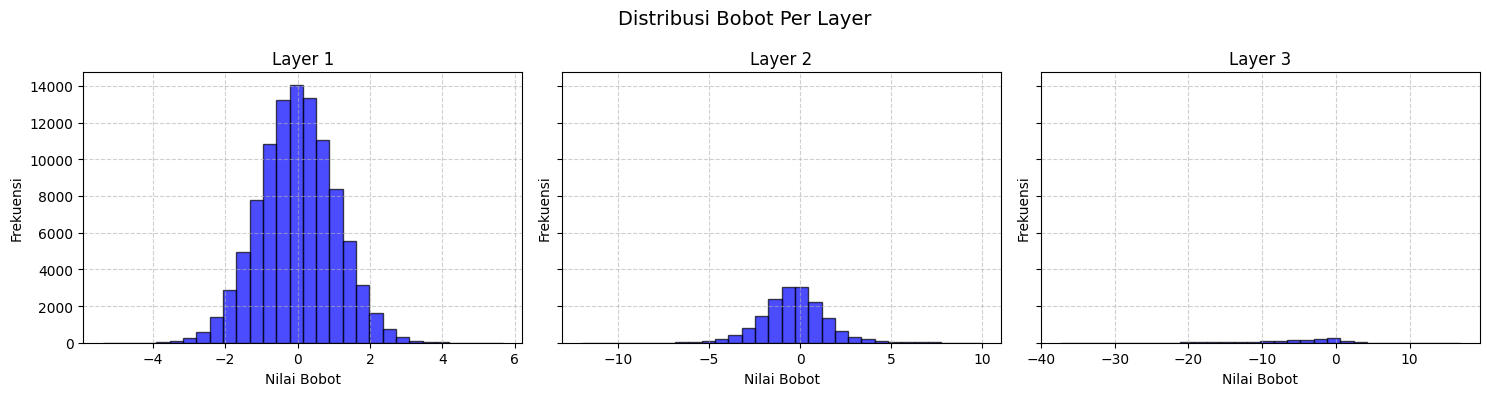

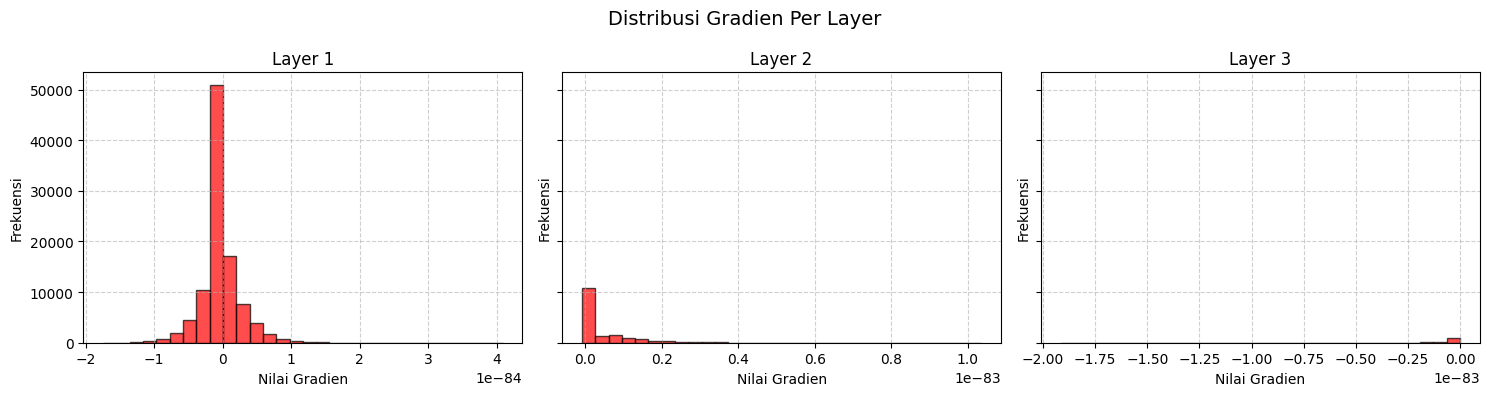

In [12]:
depth = 3
width = 128
learning_rate = 0.01
activation = relu
weight_init = 'normal'

ffnn, accuracy_ffnn = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init)

y_pred_ffnn = ffnn.predict(X_test)
y_pred_labels_ffnn = np.argmax(y_pred_ffnn, axis=1)


In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(width,) * (depth - 1),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=learning_rate,
                    max_iter=3,
                    random_state=42)

mlp.fit(X_train, np.argmax(y_train_oh, axis=1))

y_pred_sklearn = mlp.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
print(f"Akurasi Model FFNN      : {accuracy_ffnn:.2f}%")
print(f"Akurasi MLP Sklearn     : {accuracy_sklearn:.2f}%")


Akurasi Model FFNN      : 10.52%
Akurasi MLP Sklearn     : 0.92%
